In [1]:
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import random
import scipy
import seaborn as sns
import sys
from astropy.io import fits
from comet_ml import Experiment
from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchmetrics import Dice
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import segmentation_models_pytorch as smp

/tmp/ipykernel_75409/1450846592.py:16: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [2]:
hiperparametros = {'nombre_notebook': 'Evaluation_NISP_J_1000_imgs.ipynb',
                    'nombre_experimento' : 'Evaluation_NISP_J_1000_imgs',
                    'nombre_mejor_modelo_entrenado' : 'NISP_J_1000imgs_v2',
                    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                    'ruta_galaxias' : 'galaxies_test_NISP_J/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras' : 'masks_NISP_J/mask_',
                    'ancho_imagen_original' : 200,
                    'alto_imagen_original' : 200,
                    'ancho_imagen_deseado' : 224,
                    'alto_imagen_deseado' : 224}

In [3]:
def get_galaxy_number(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[4]

def get_galaxy_magnitude(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[5]

def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def imagen_logaritmica(img: np.ndarray)->np.ndarray:
    """
    Escalamos de forma logarítmica la imagen para aumentar el contraste
    """
    img_log = np.log(img, where=(img!=0))
    valor_minimo = np.min(img_log)
    np.putmask(img_log, img!=0, img_log+abs(valor_minimo))
    return img_log

In [4]:
class MyDataset(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        ruta = self.galaxias_con_colas_de_marea[index]
        magnitud_real = get_galaxy_magnitude(ruta)
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        #x = normalize_01(x)
        x_tensor_visualizar = copy.copy(x)
        x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor, ruta, magnitud_real, x_tensor_visualizar
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)

In [5]:
dice = Dice(num_classes=2, average='macro', ignore_index=0)
imagenes_test = glob.glob(hiperparametros['ruta_galaxias'])
#Cargamos el dataset de test
test_dataset= MyDataset(imagenes_test)
imagenes_test.sort()
print("Number of valid images: " + str(len(imagenes_test)))
device = hiperparametros['device']
#dice.to(device)

Number of valid images: 1745


In [6]:
unet = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [7]:
#Cargamos el modelo previamente entrenado
ruta_modelo = hiperparametros['nombre_mejor_modelo_entrenado']
mejor_modelo = unet
mejor_modelo.load_state_dict(torch.load(ruta_modelo))
mejor_modelo.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [8]:
def guardar_imagen_plt(foto: np.ndarray, indice, nombre):
    plt.axis("off")
    plt.imshow(foto, interpolation='none', origin="lower")
    plt.savefig("imgs_guardadas_vis/"+str(nombre)+"_"+str(indice), pad_inches=0, bbox_inches="tight")

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.2527 :


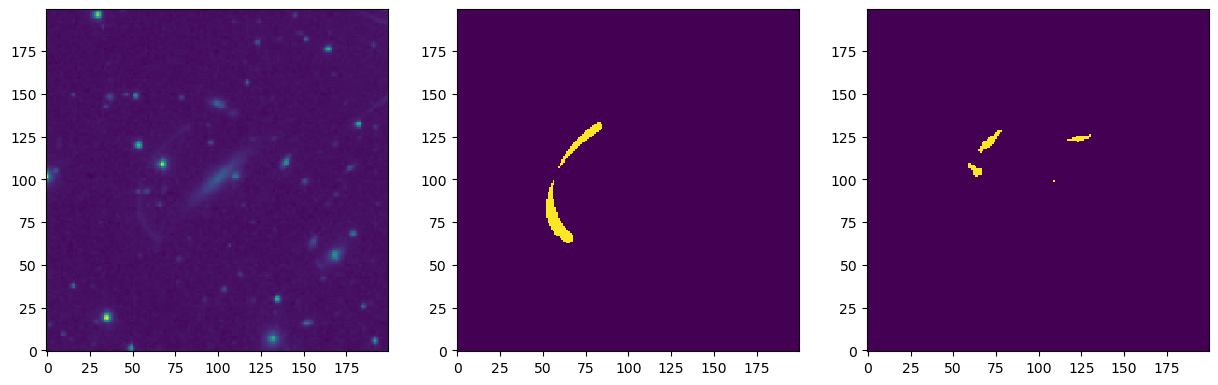

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.5487 :


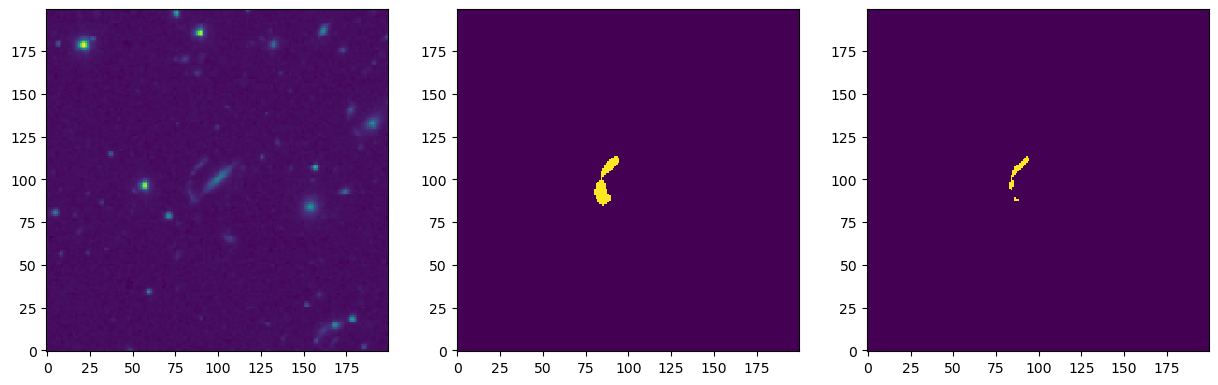

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.6717 :


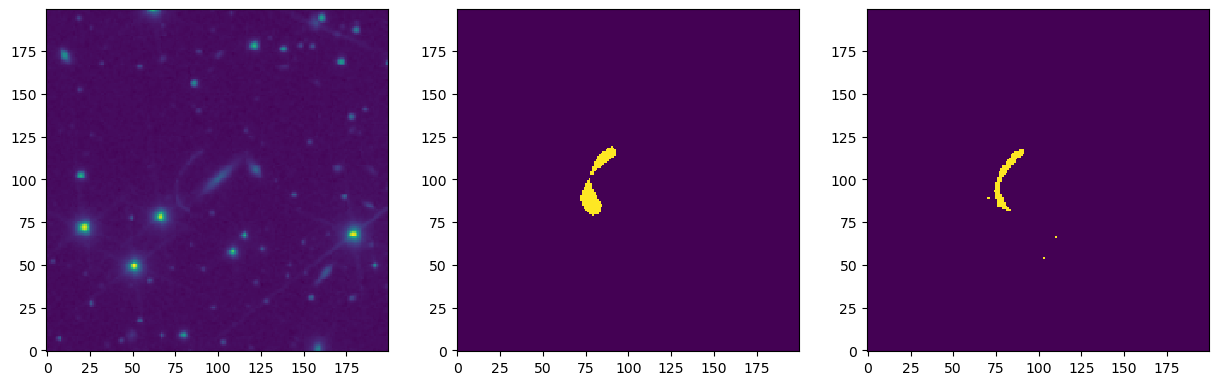

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.8426 :


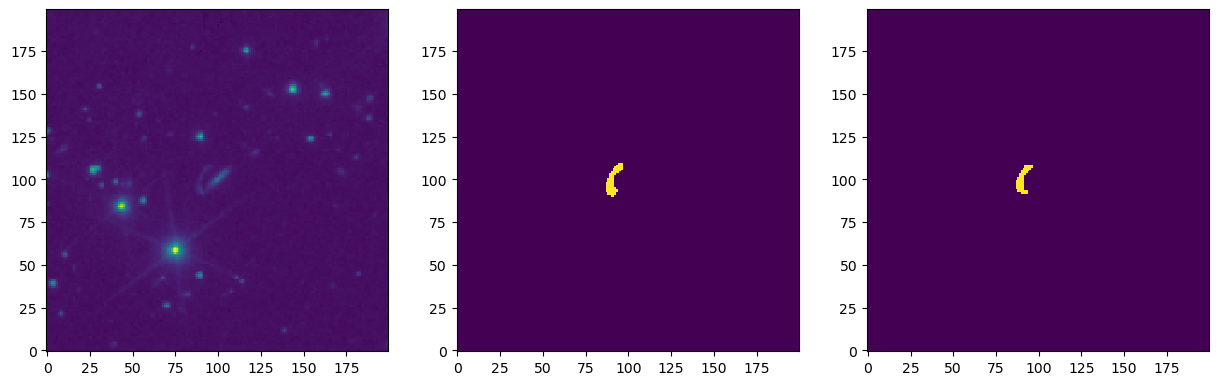

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.5 :


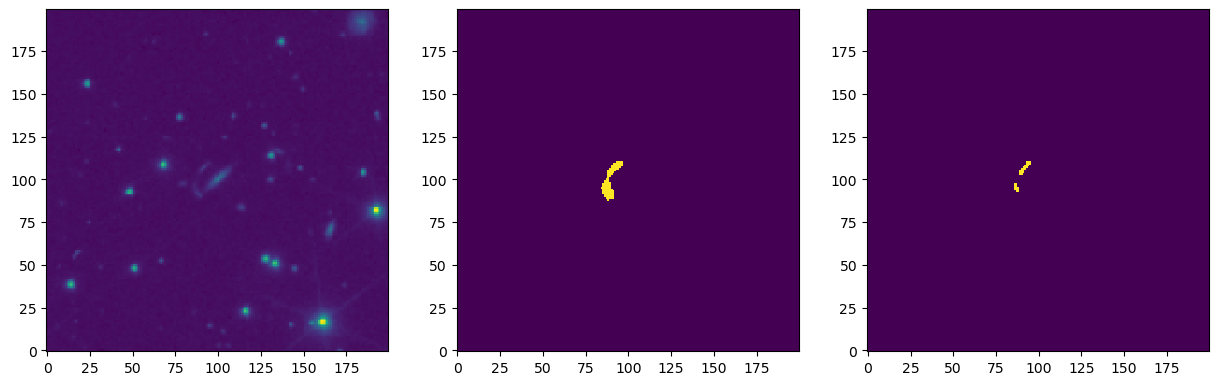

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.5316 :


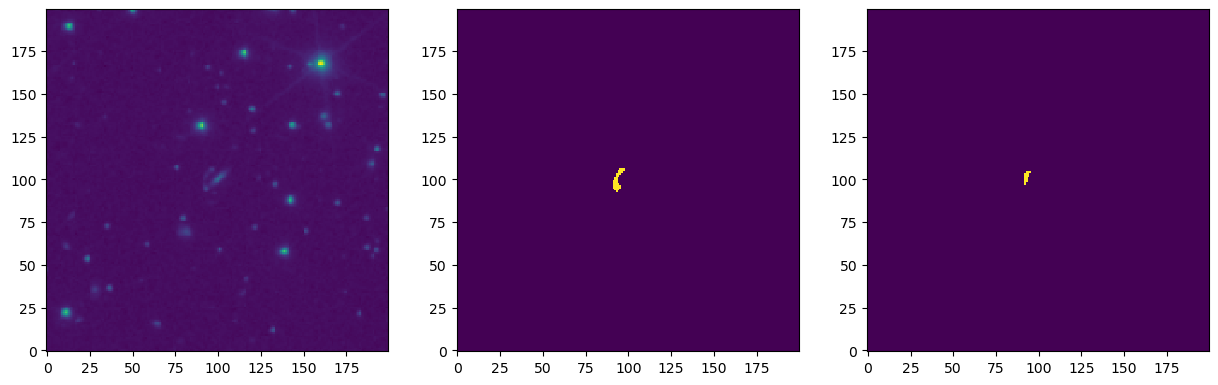

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.8193 :


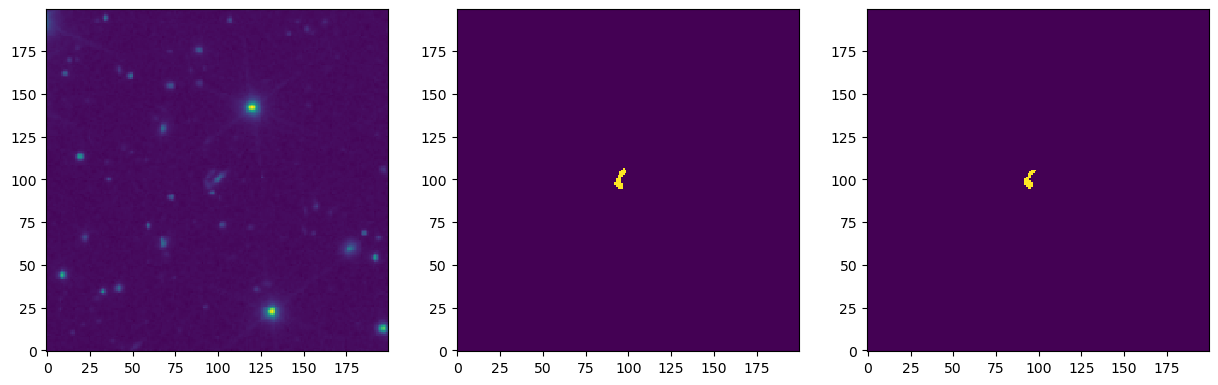

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.6977 :


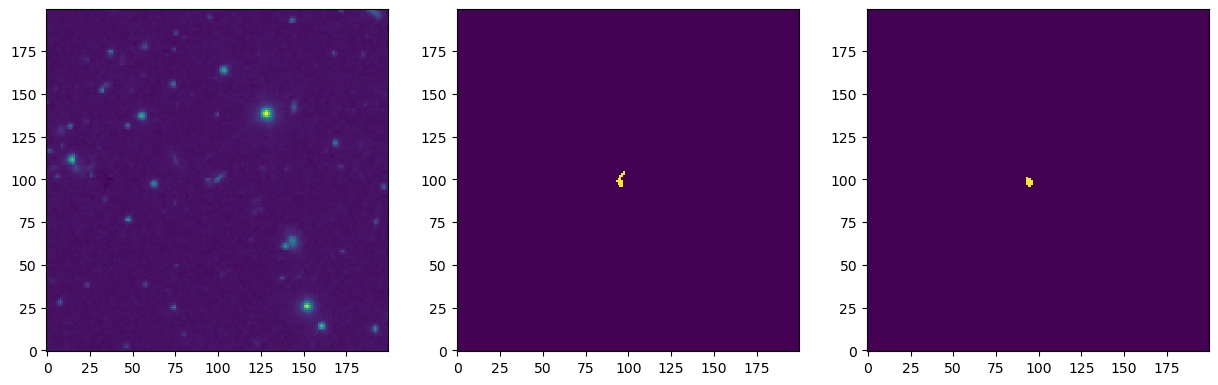

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.6792 :


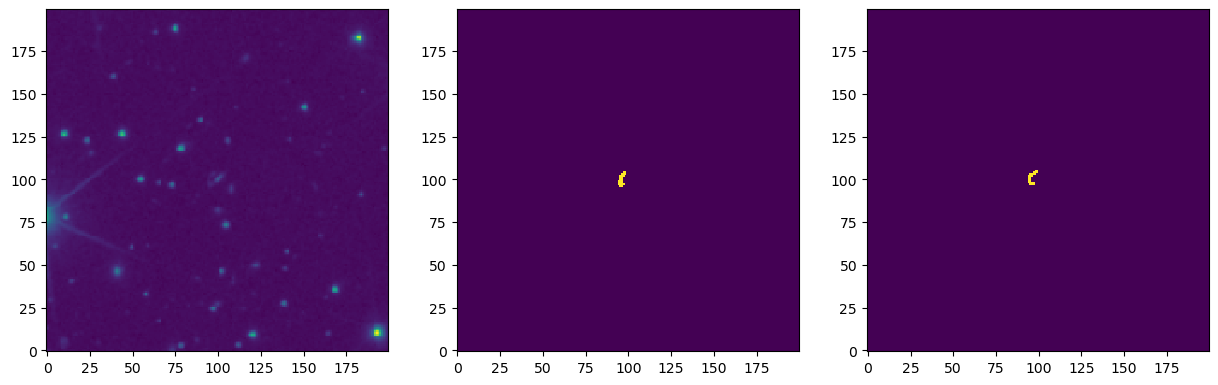

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.7503 :


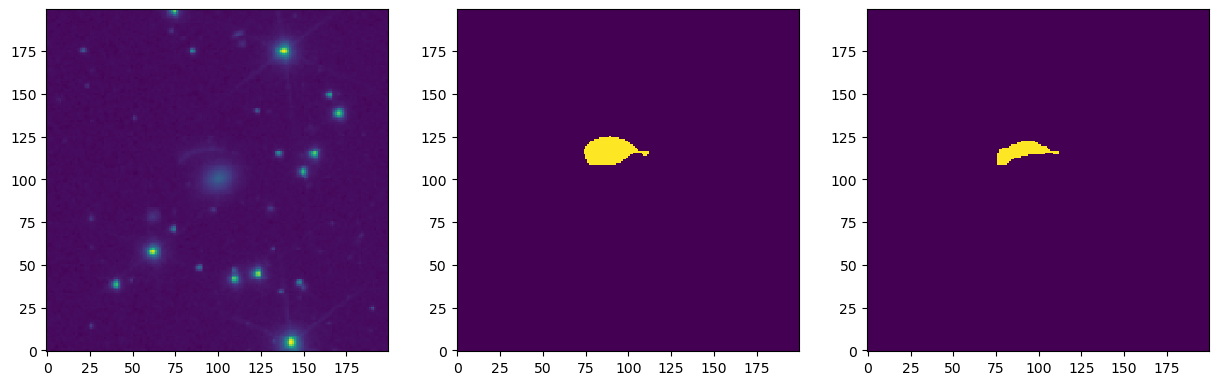

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.6269 :


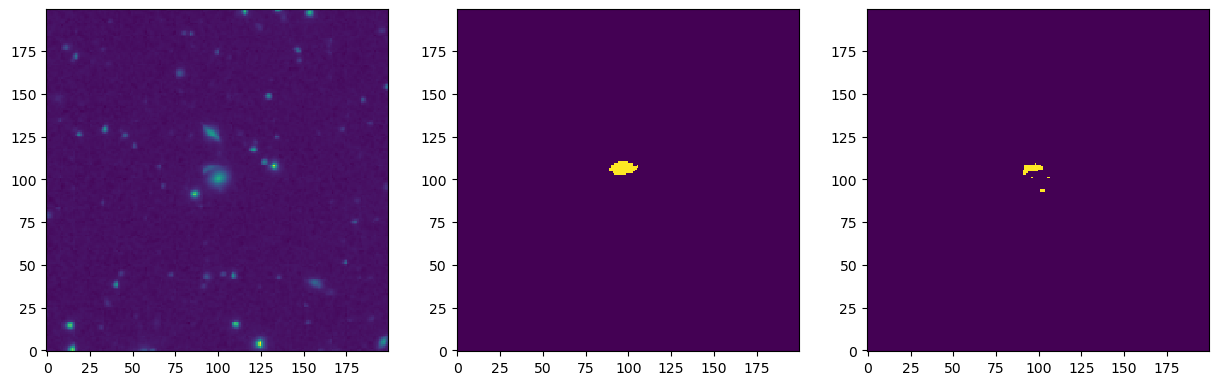

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.6555 :


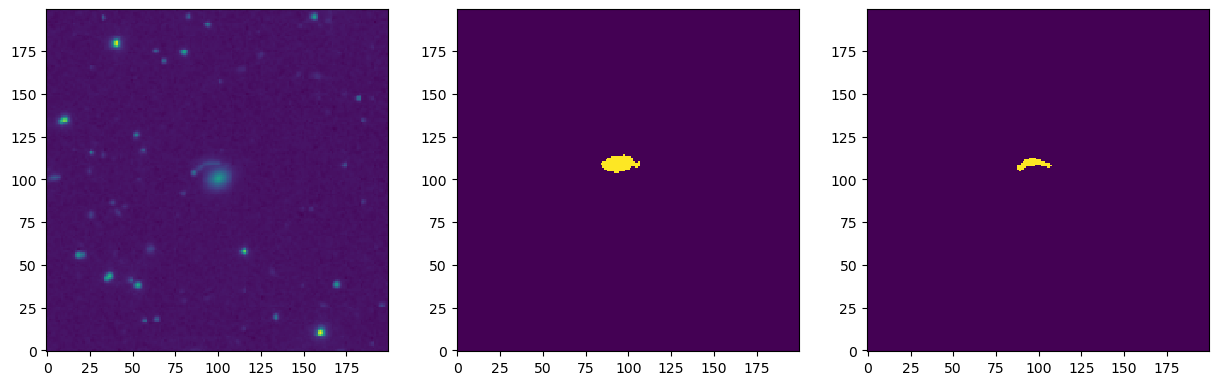

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.7033 :


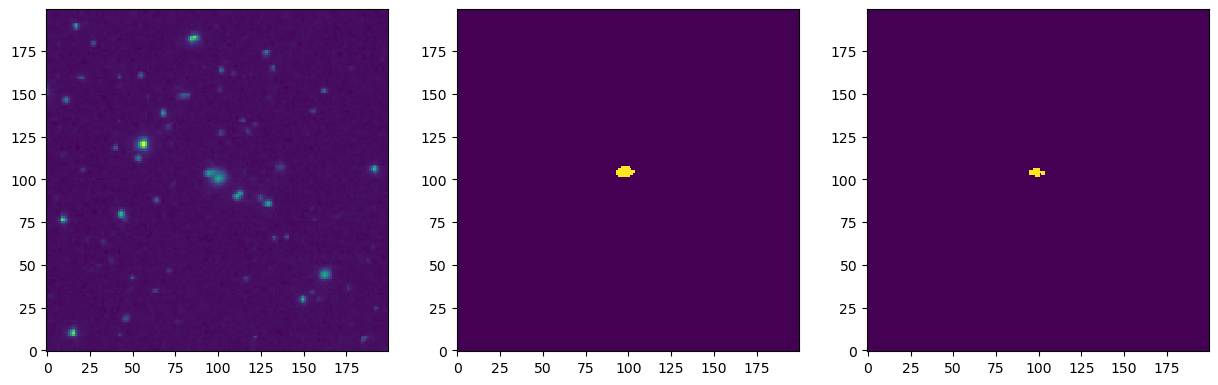

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.7111 :


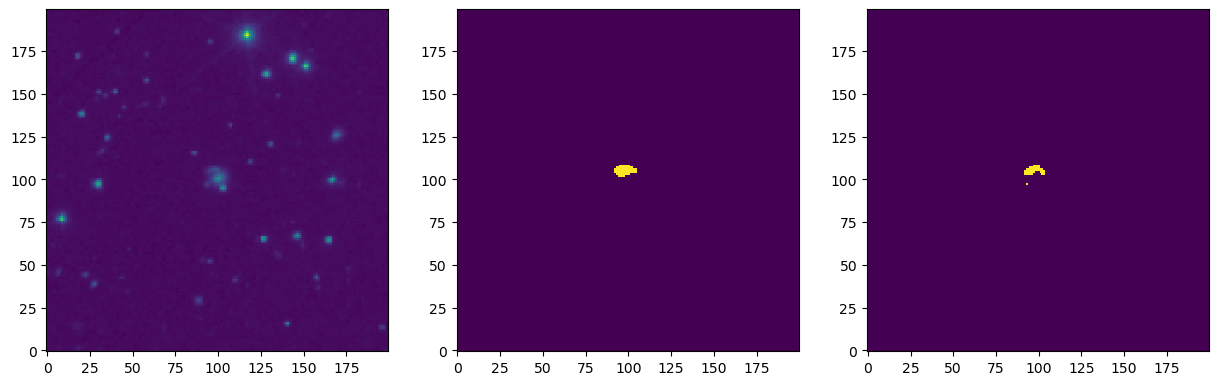

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.807 :


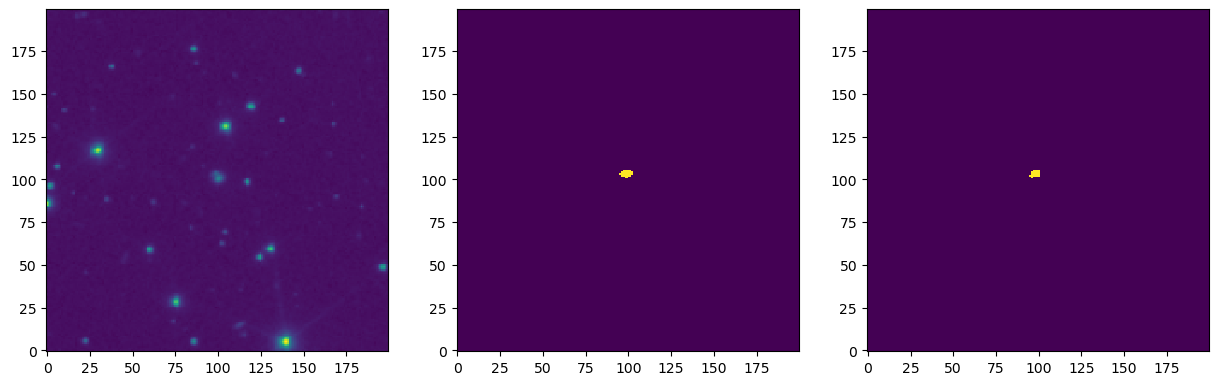

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.5946 :


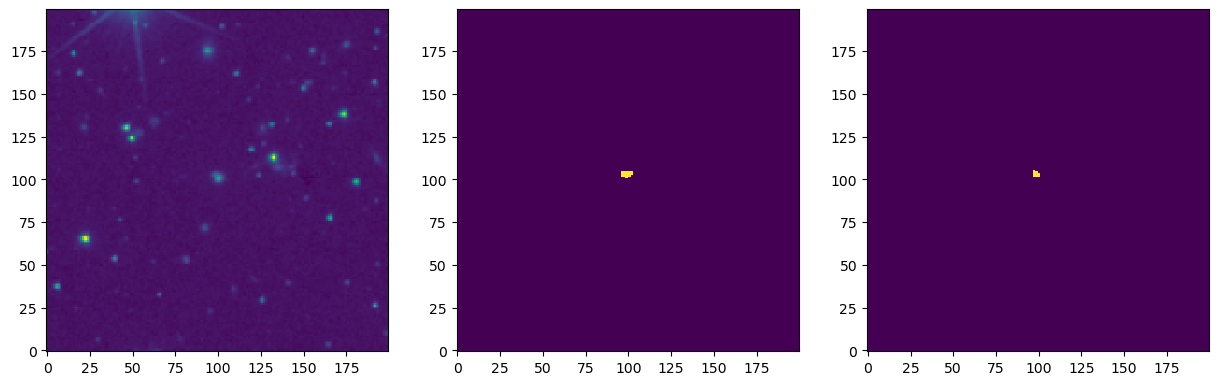

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.6061 :


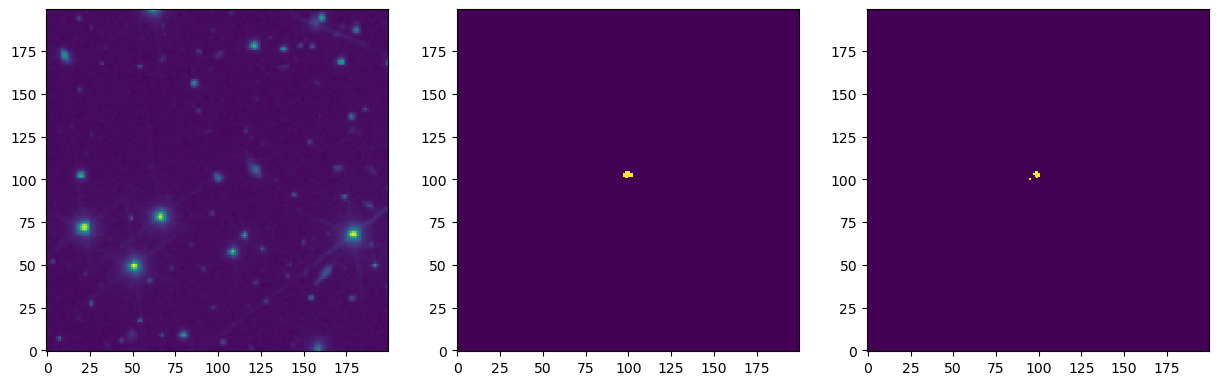

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_100_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.0 :


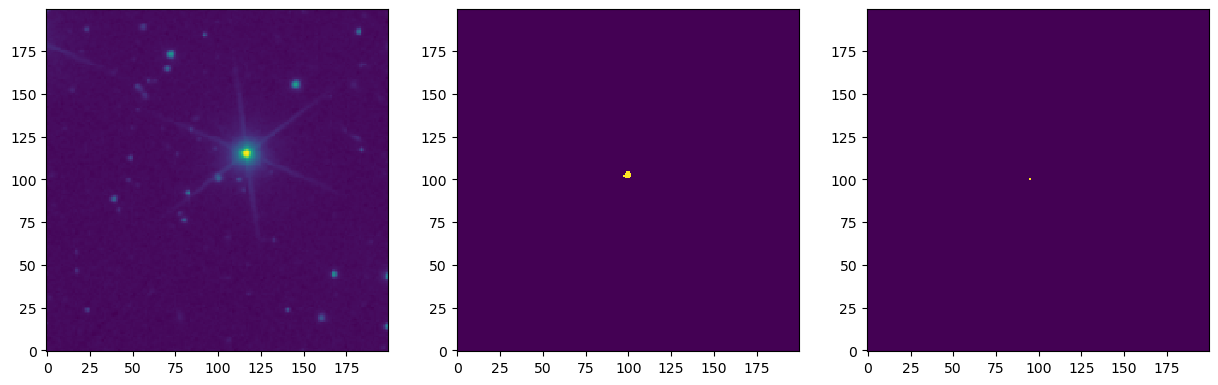

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.0075 :


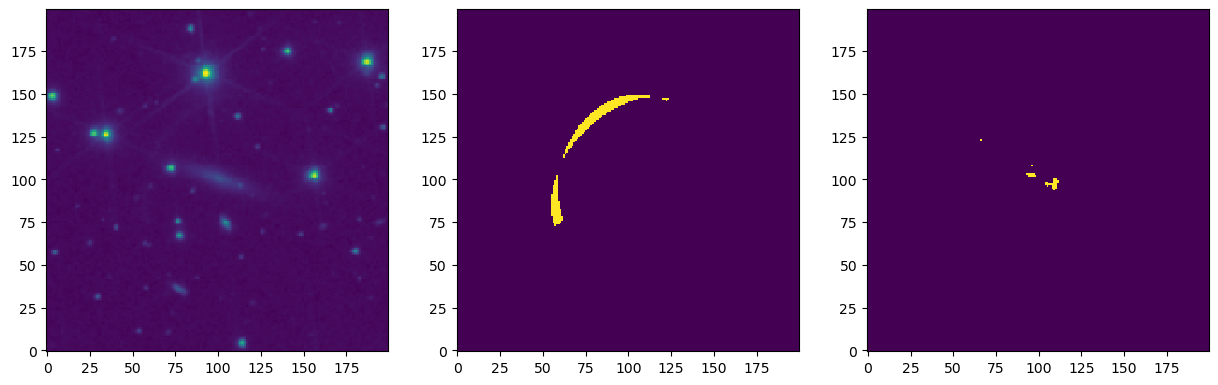

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.2934 :


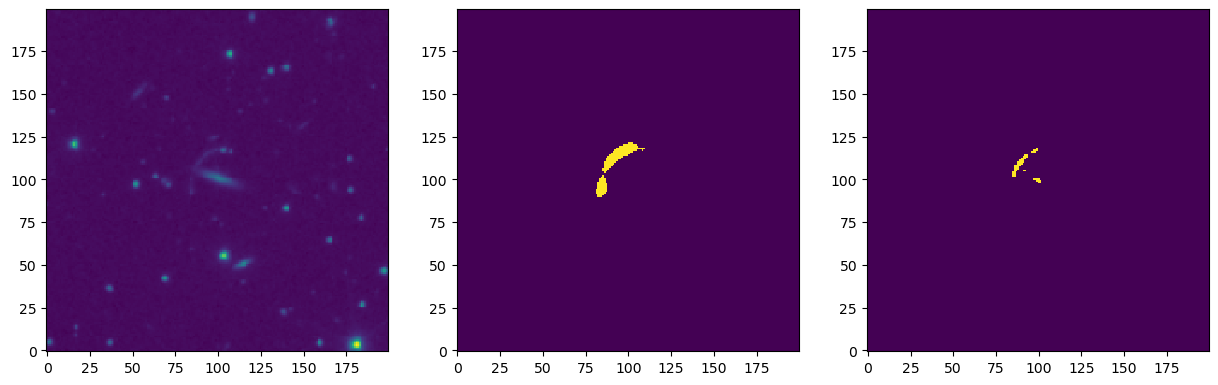

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.3241 :


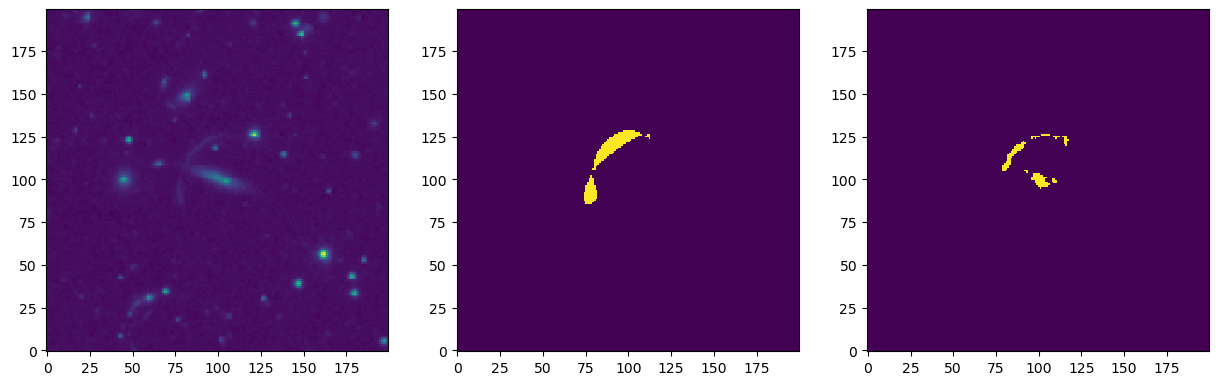

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.5625 :


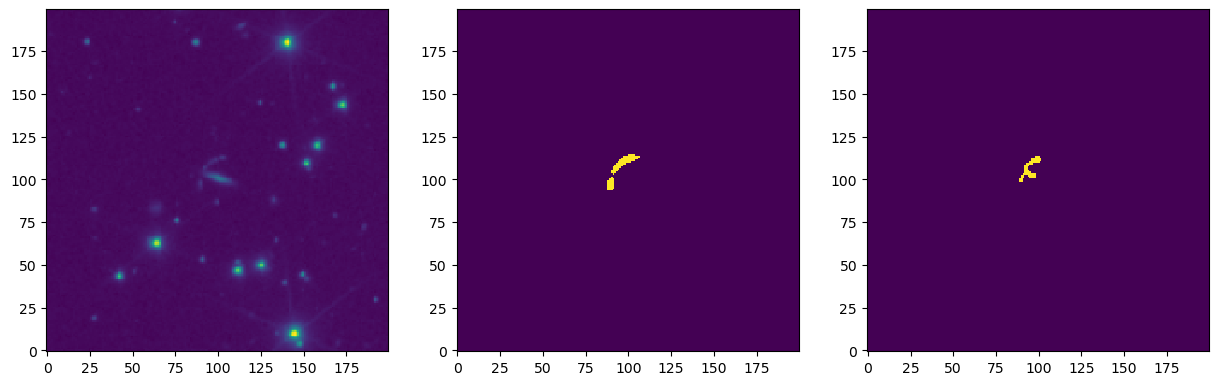

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.5017 :


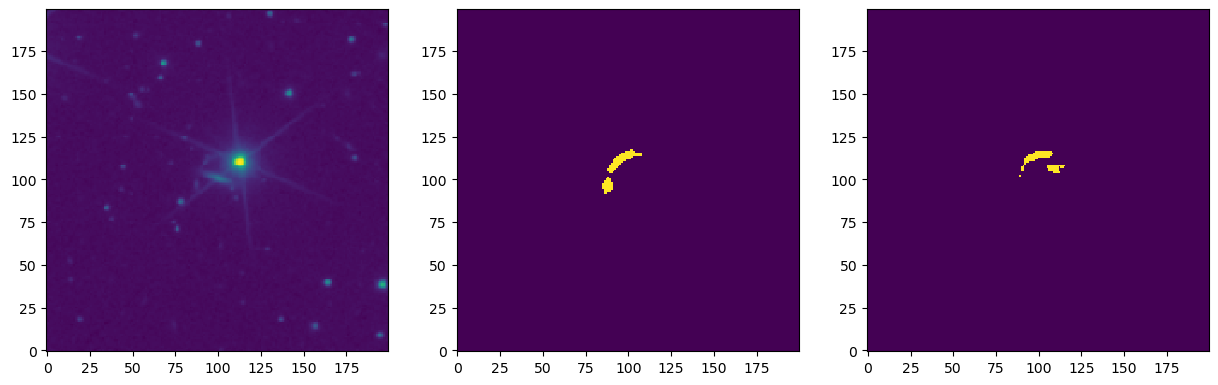

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.6759 :


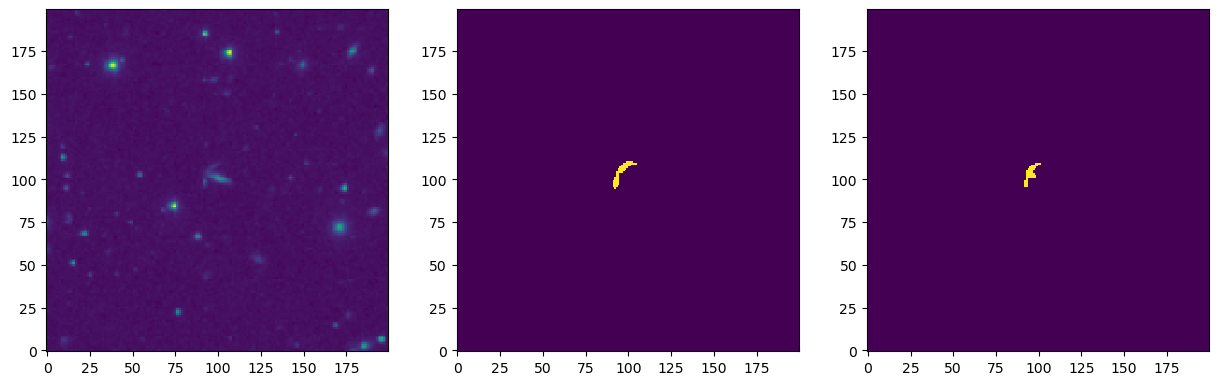

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.2683 :


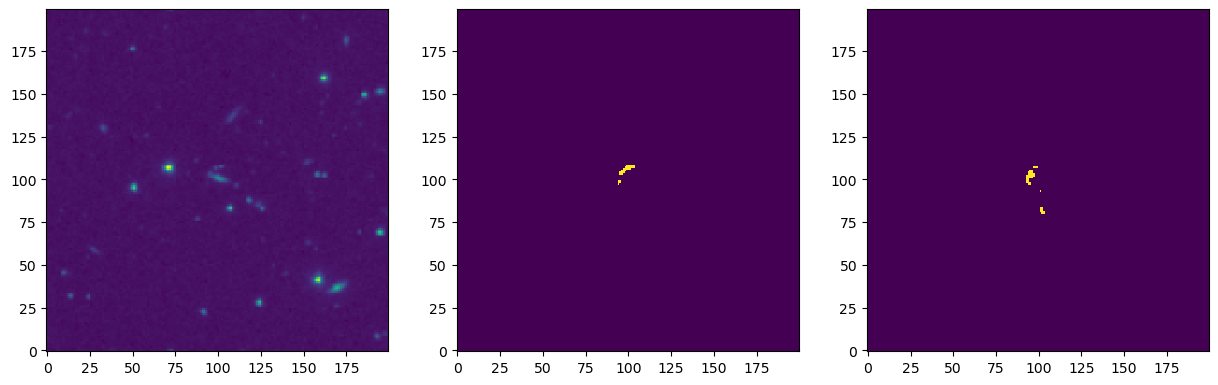

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.6131 :


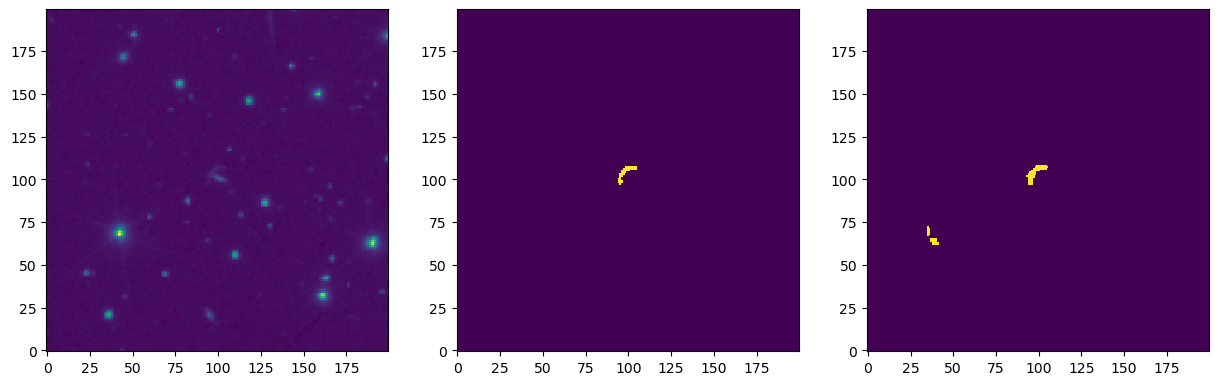

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_101_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.6667 :


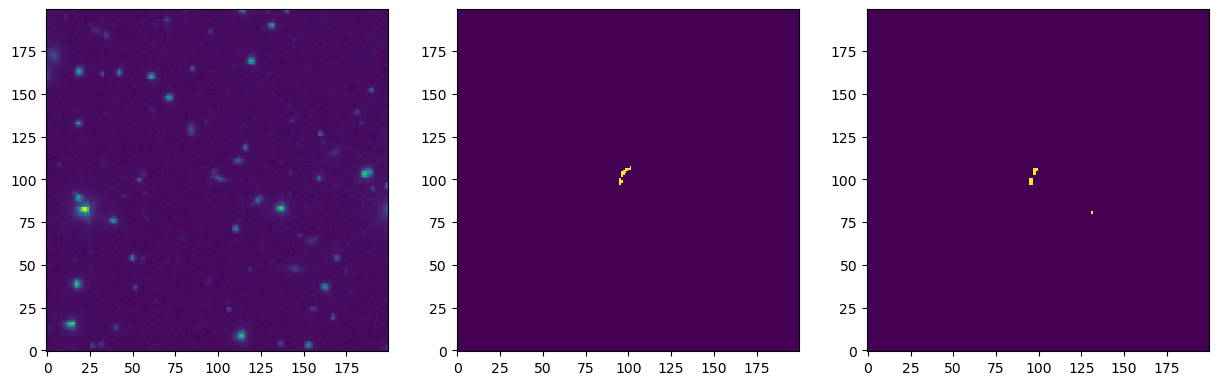

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.4965 :


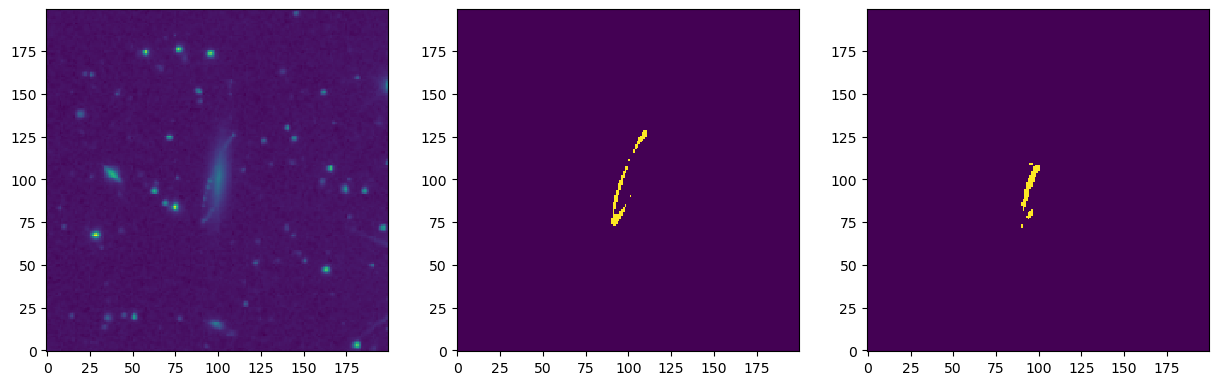

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.0706 :


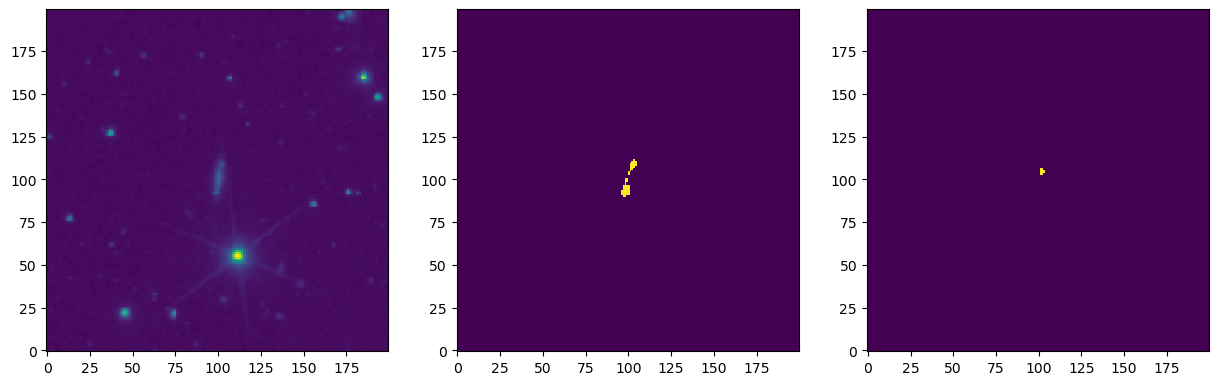

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.0 :


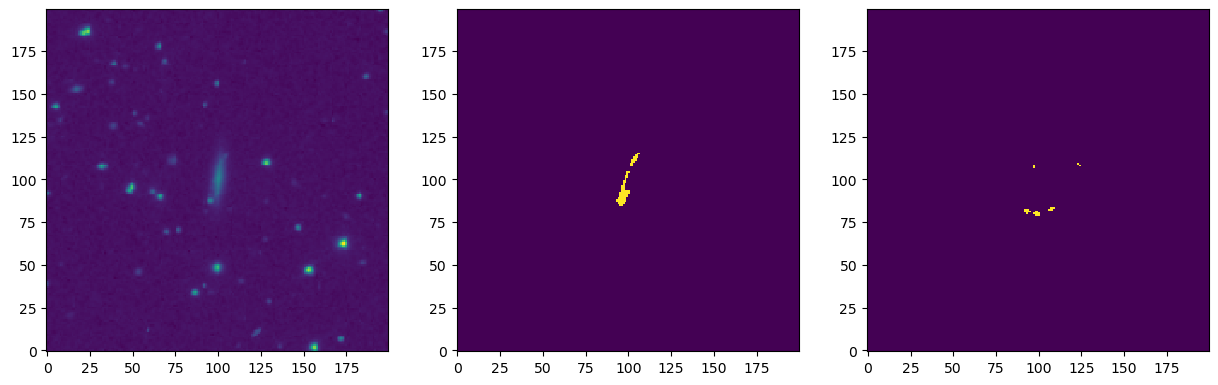

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.0625 :


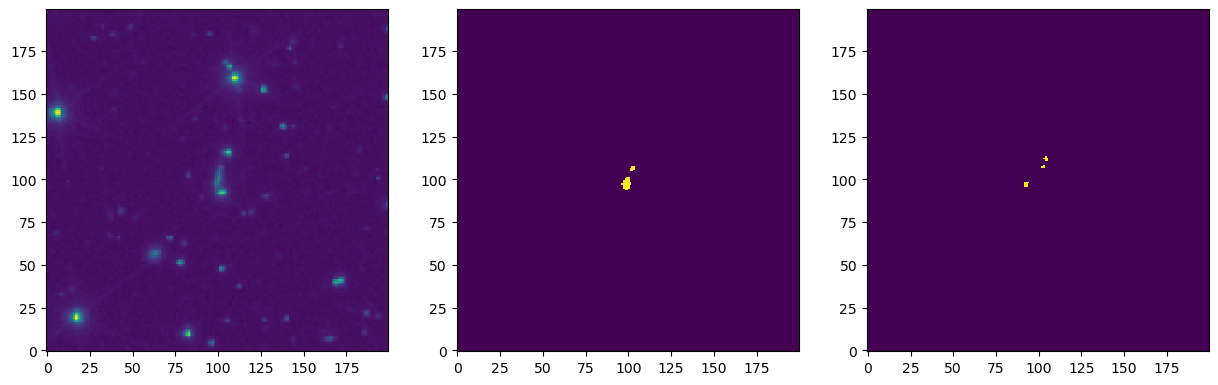

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.3171 :


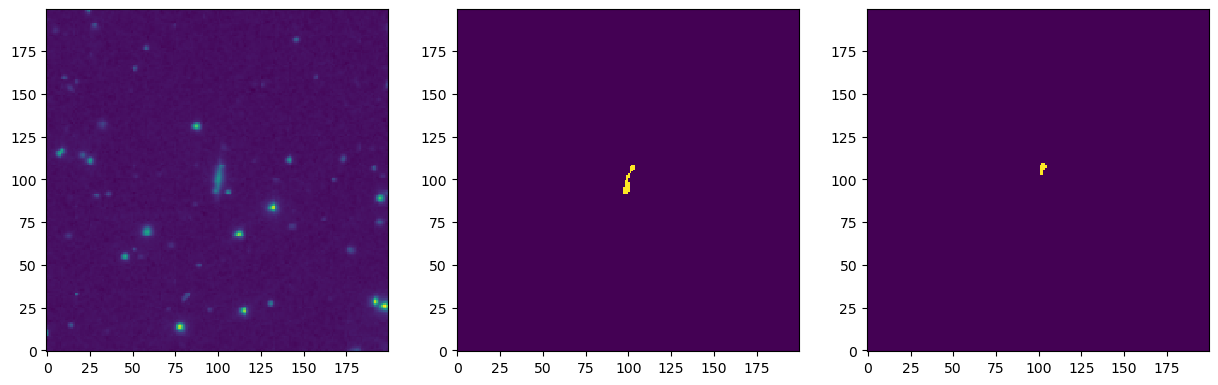

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.0 :


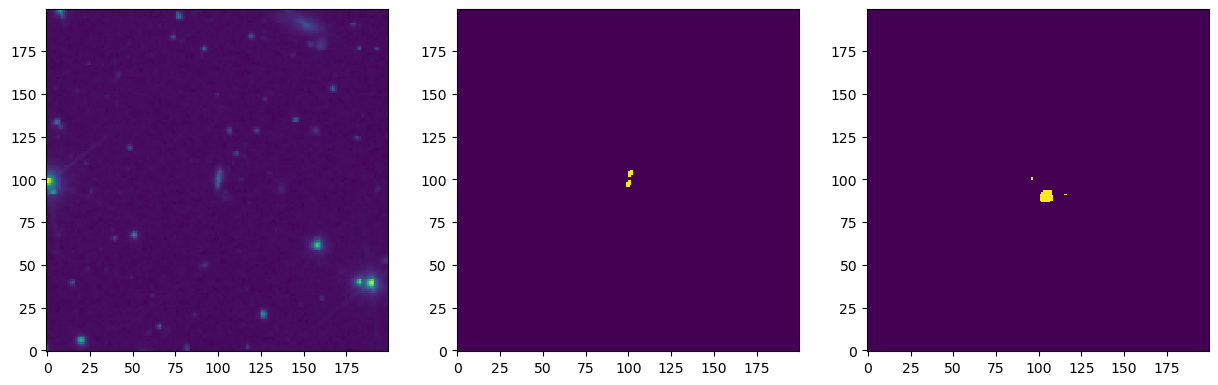

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_102_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.0 :


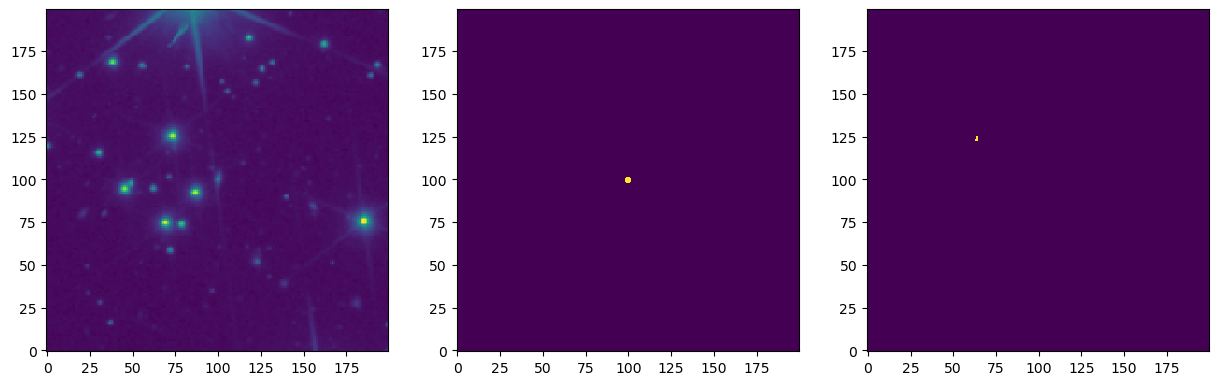

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.7239 :


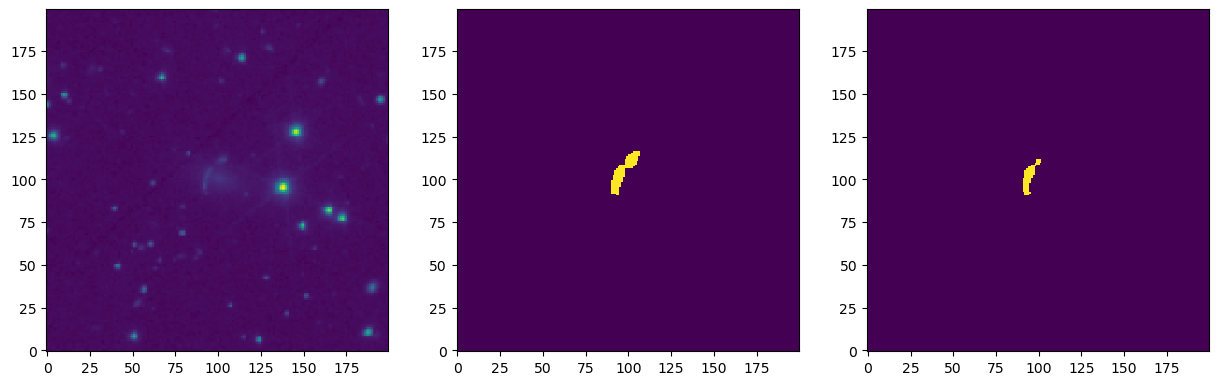

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.375 :


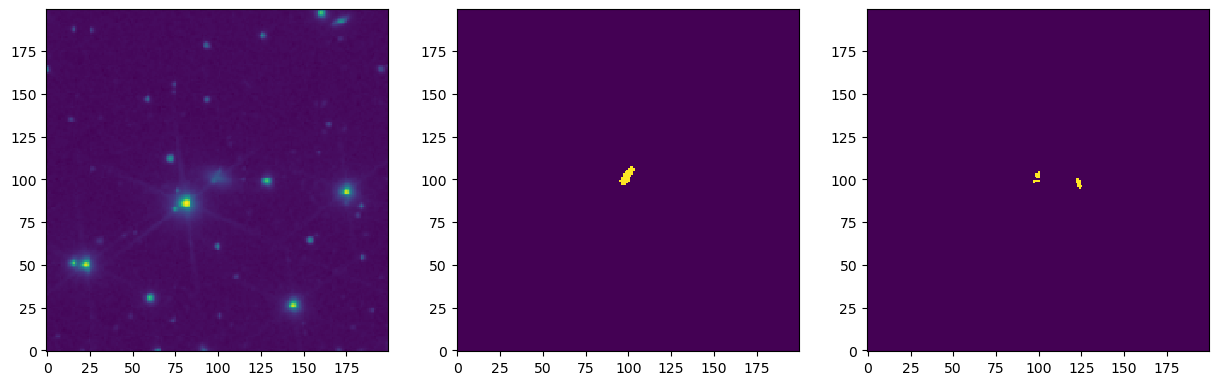

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.2544 :


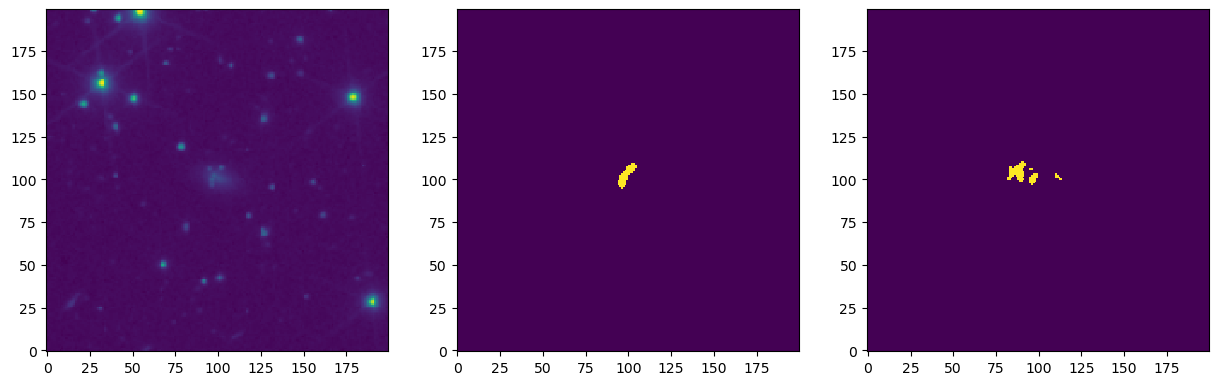

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.1649 :


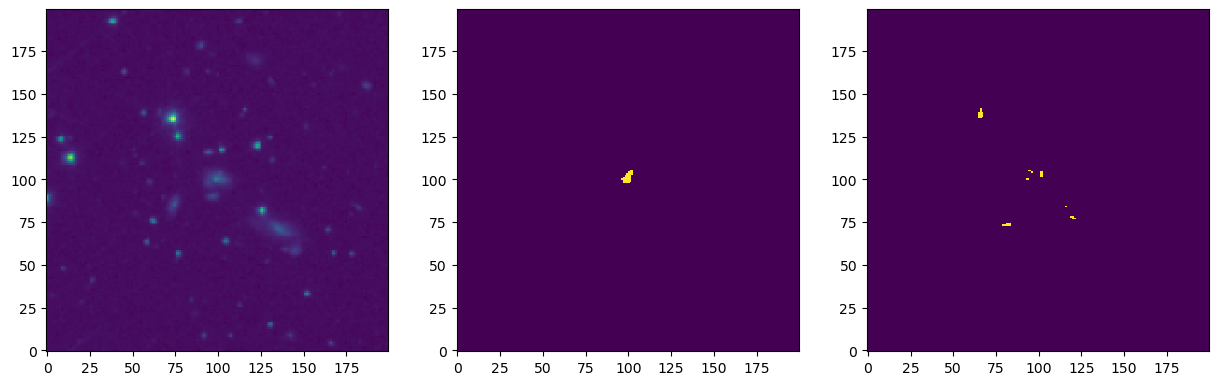

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.2047 :


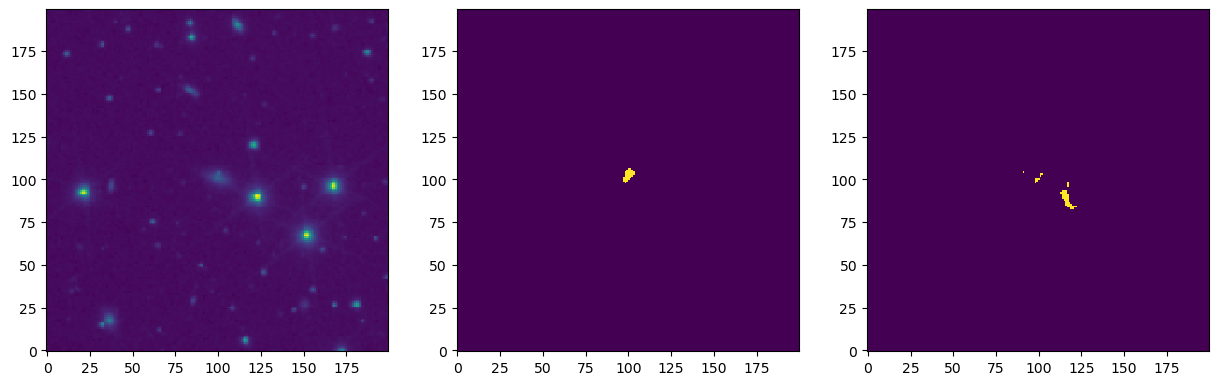

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.6383 :


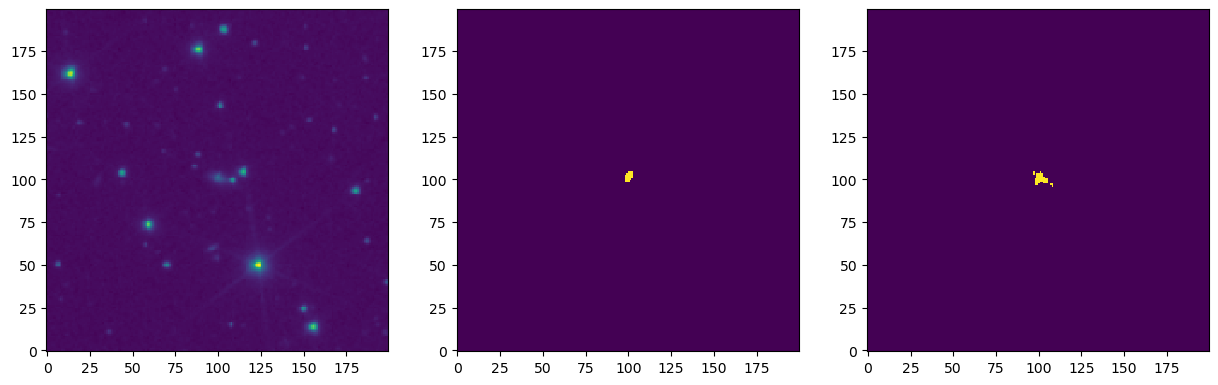

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.0 :


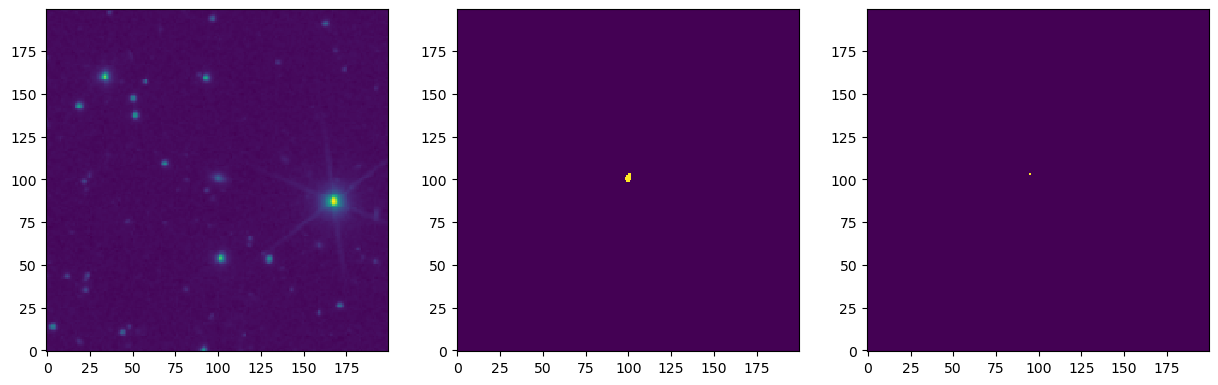

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.0 :


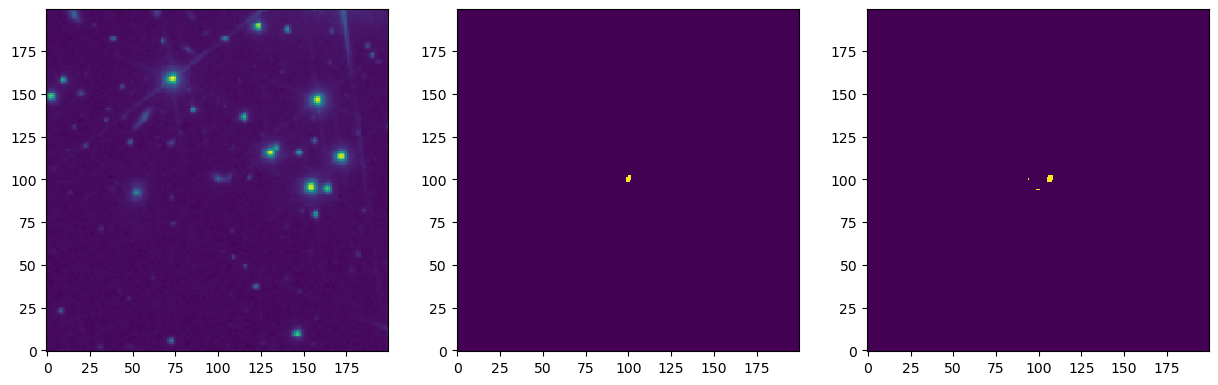

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_103_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.0 :


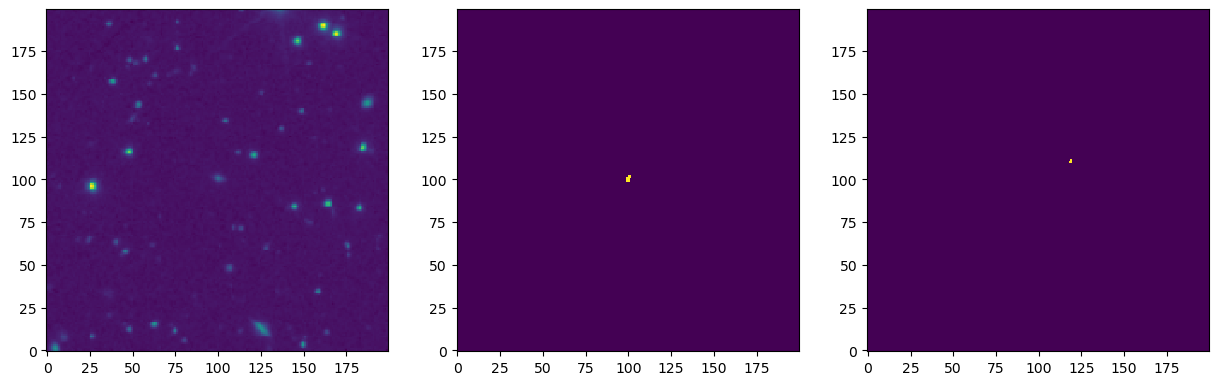

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.1173 :


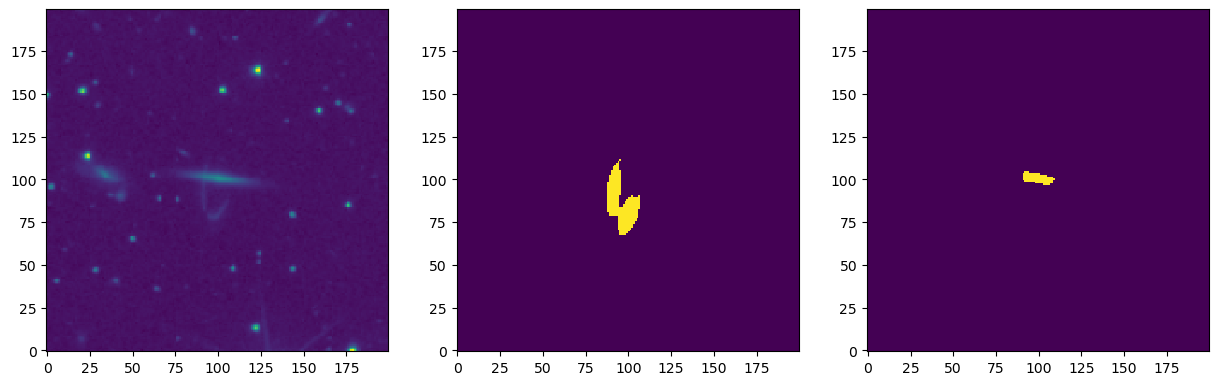

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.2697 :


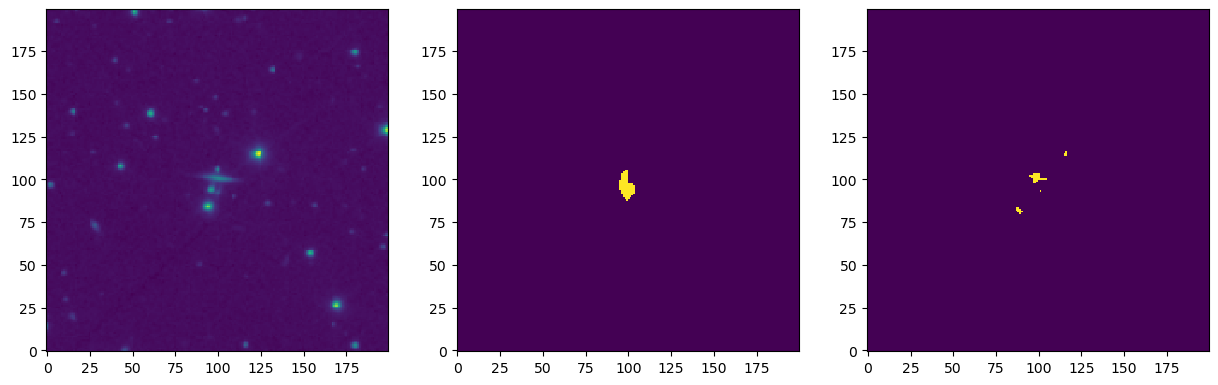

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.5817 :


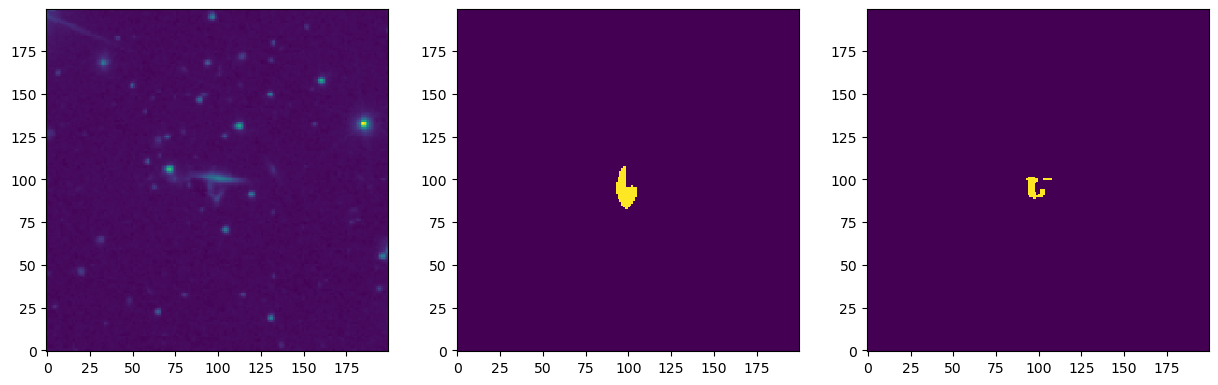

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.8333 :


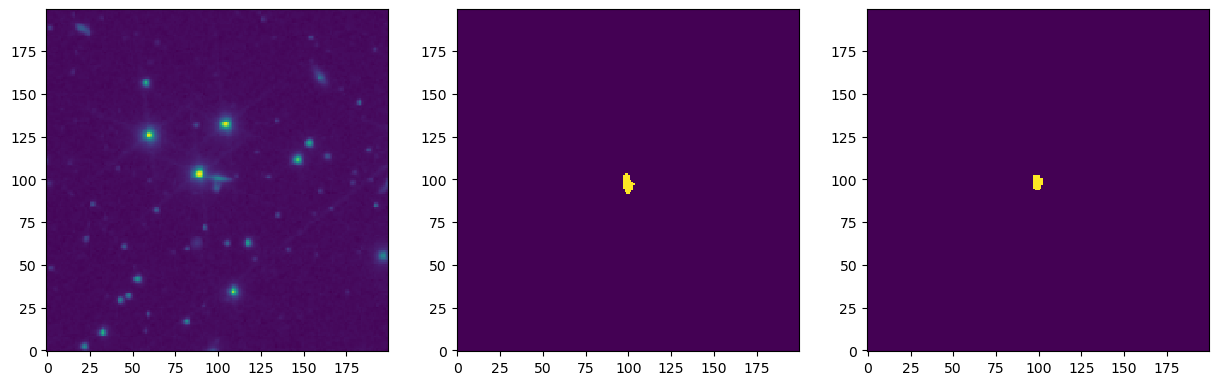

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.6526 :


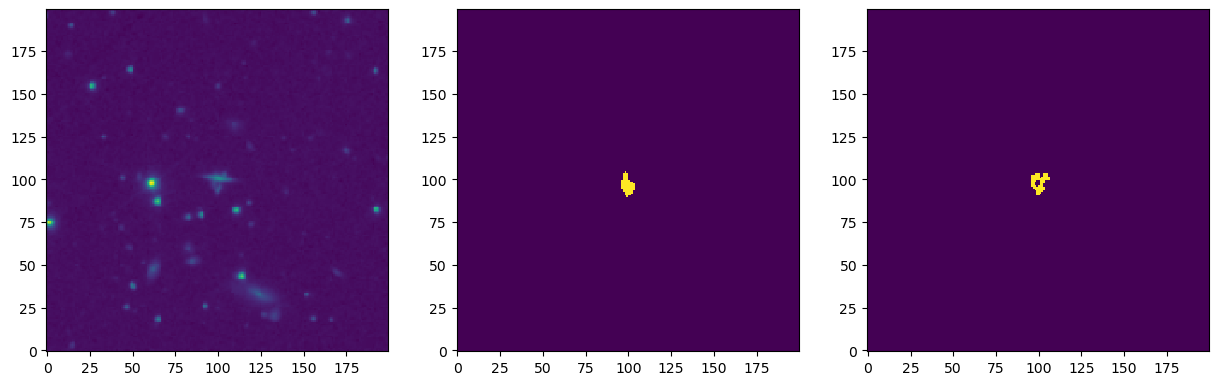

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.029 :


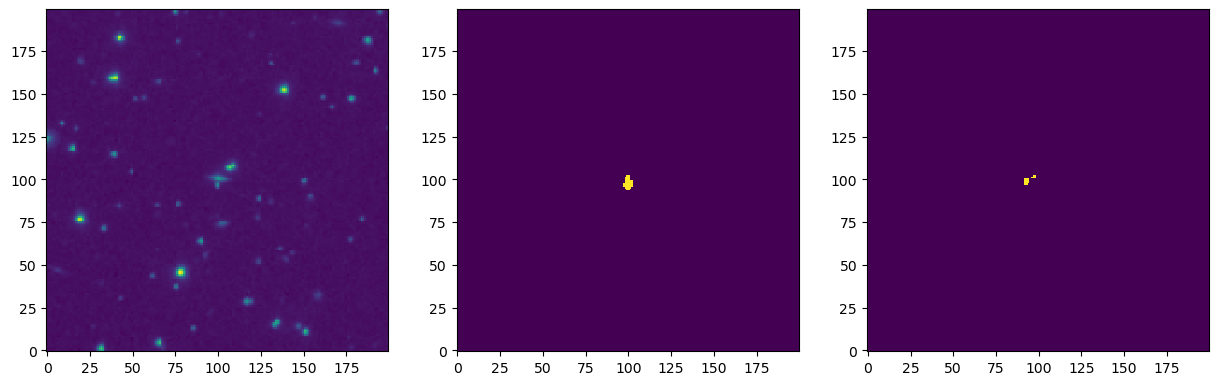

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.0174 :


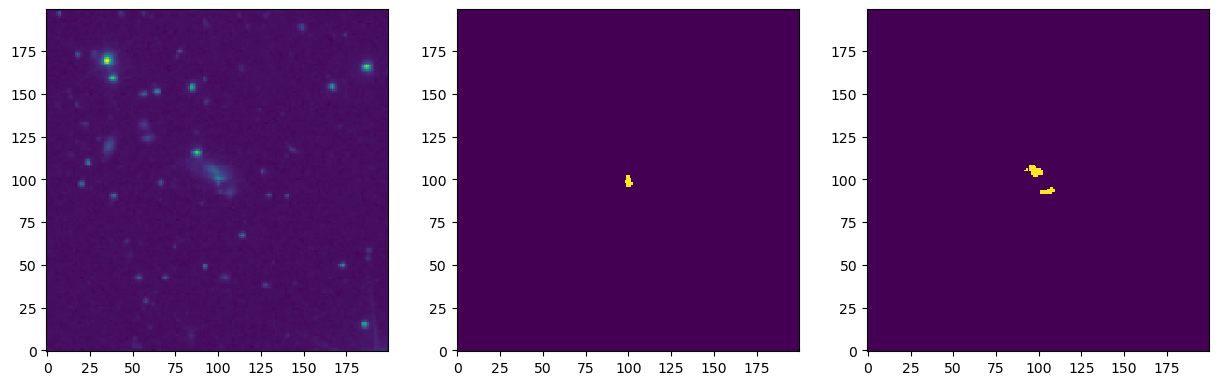

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.1379 :


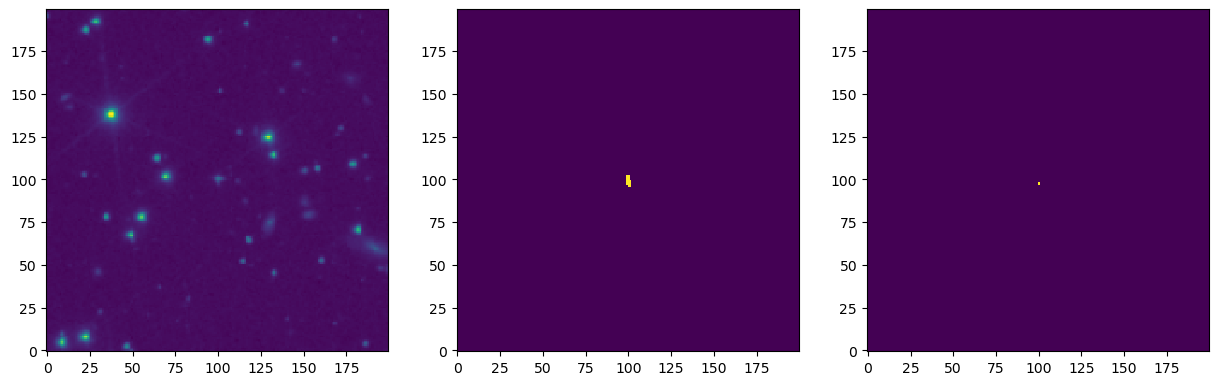

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_104_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.087 :


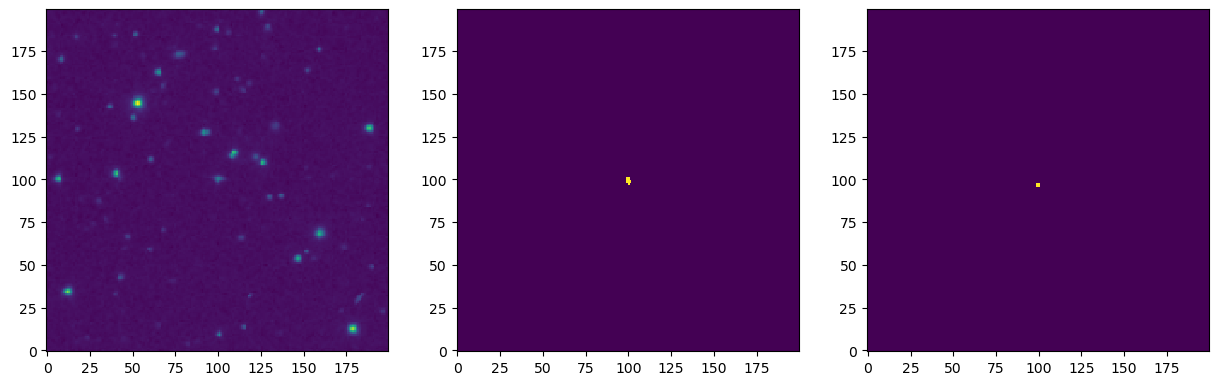

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.5176 :


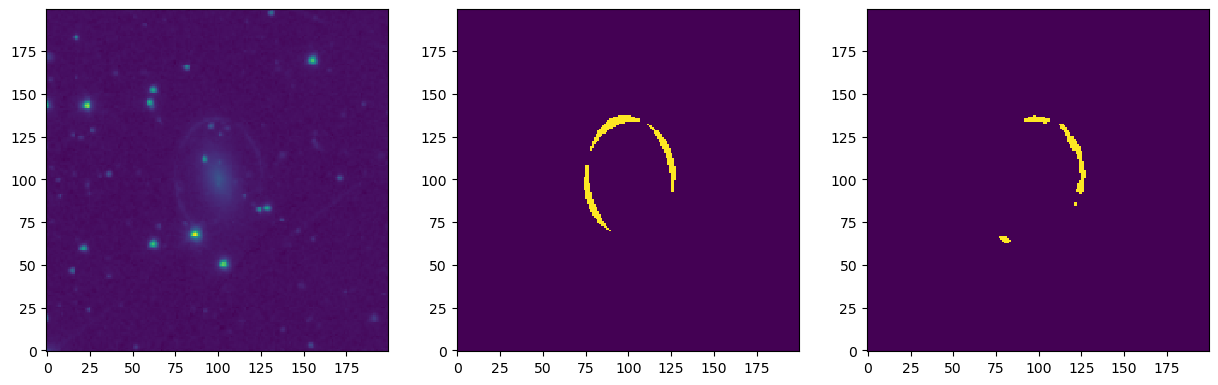

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.6647 :


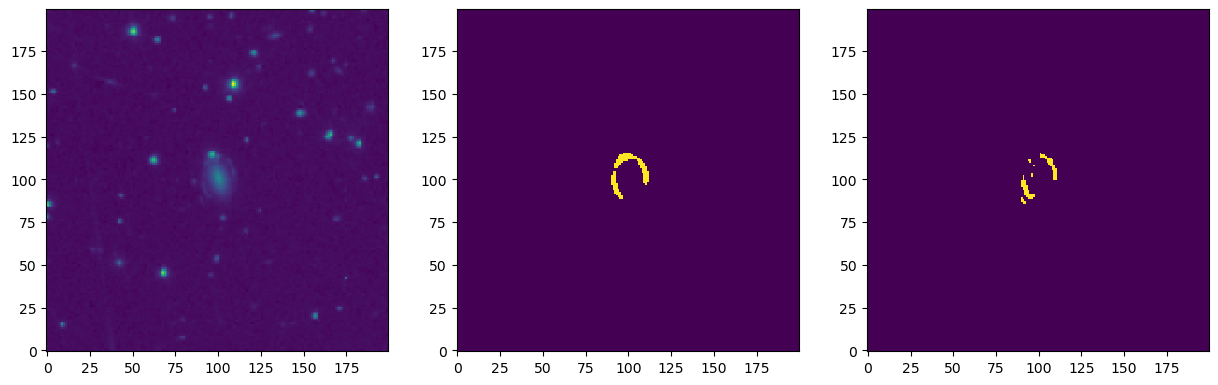

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.8125 :


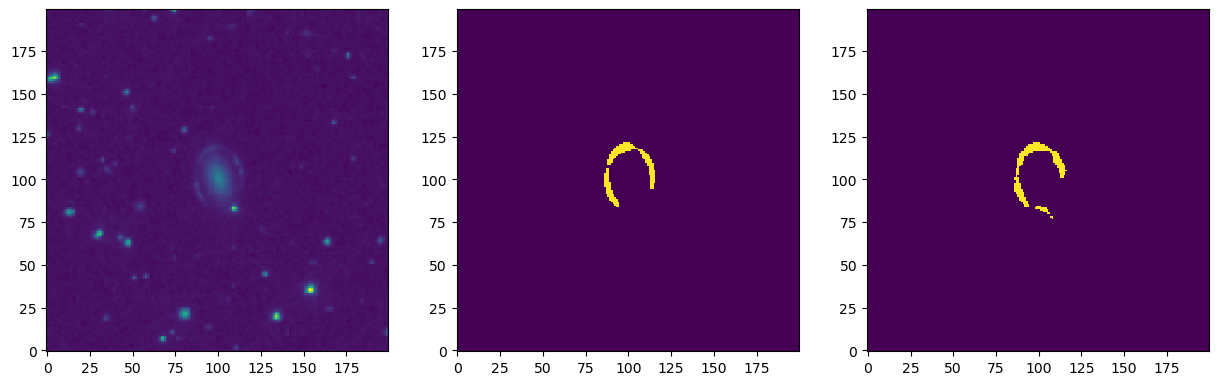

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.7876 :


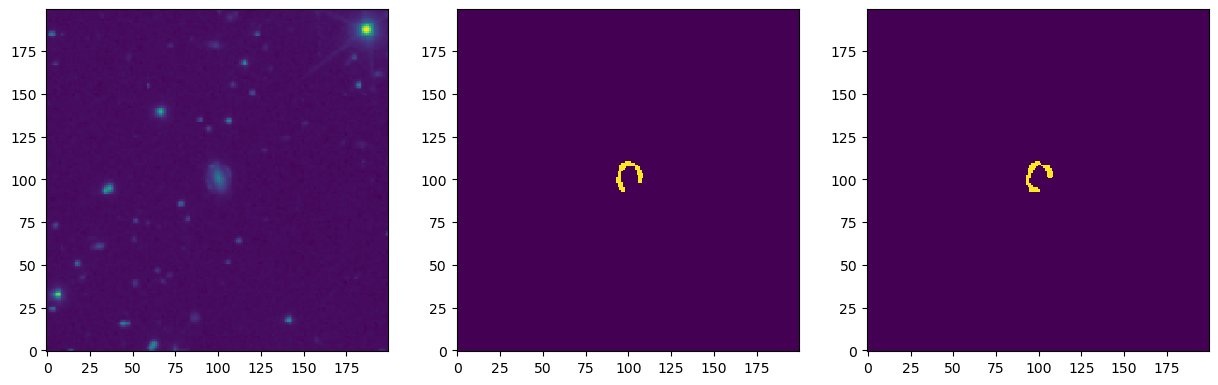

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.7183 :


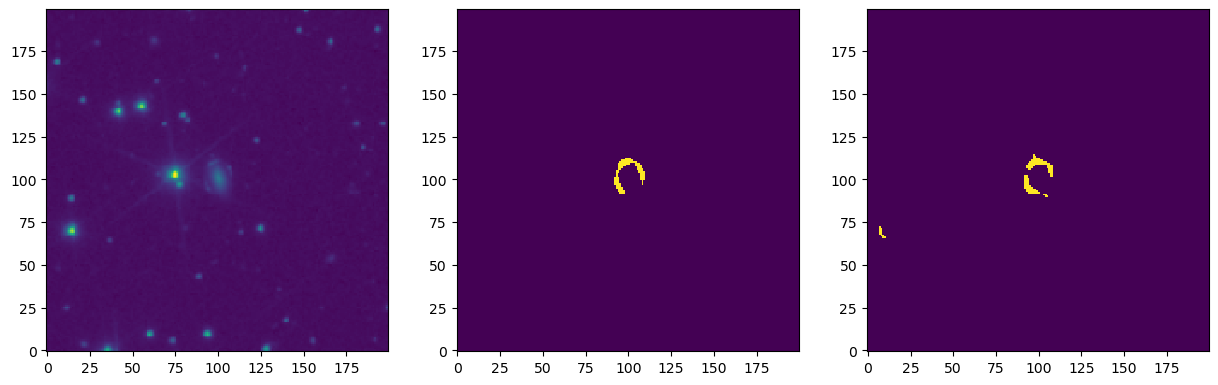

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.656 :


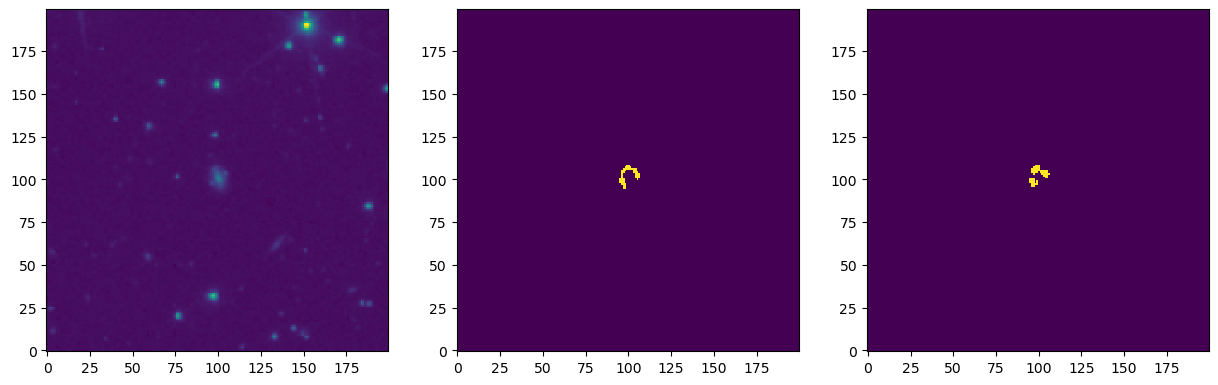

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.4938 :


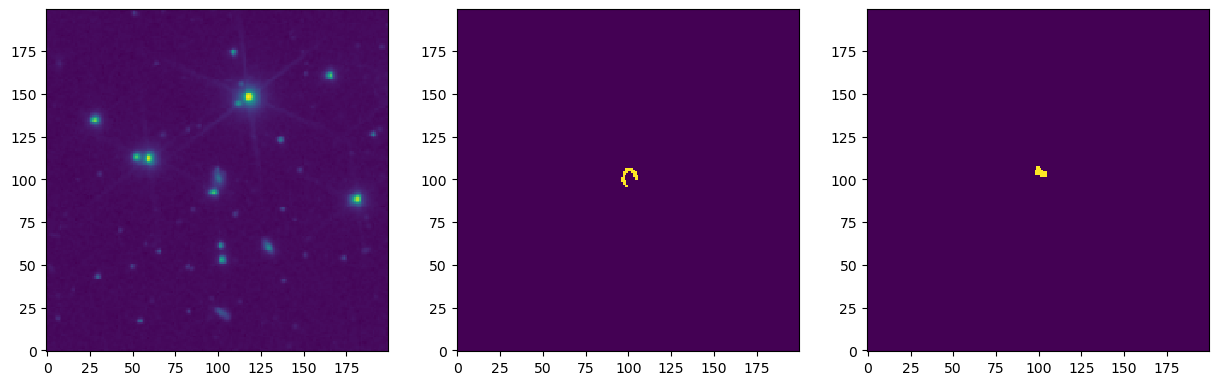

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.6214 :


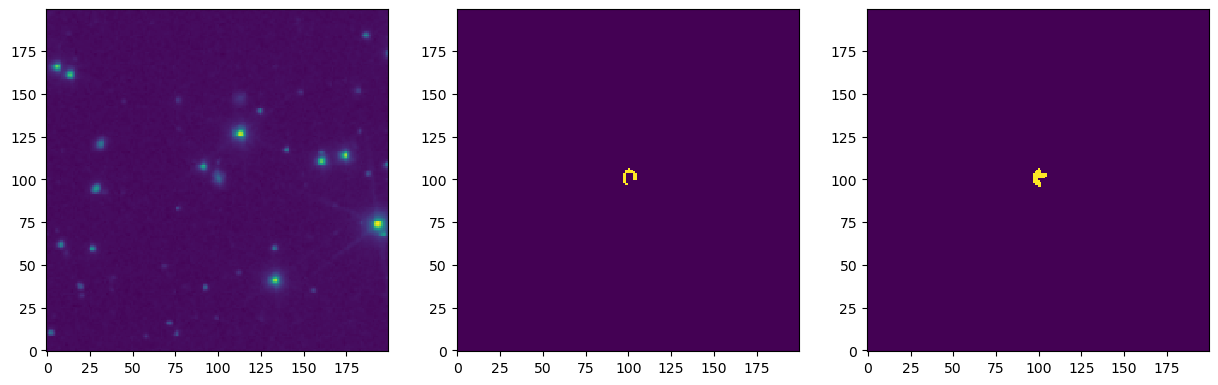

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_105_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.2703 :


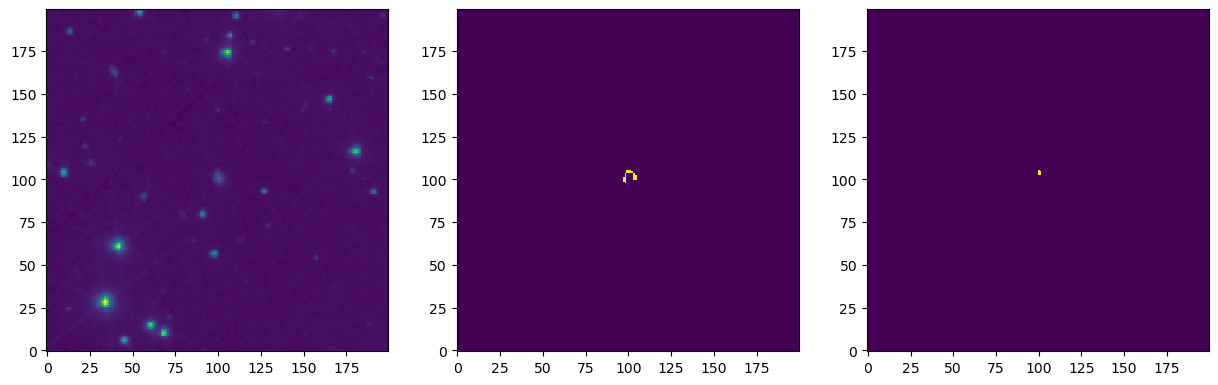

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.7445 :


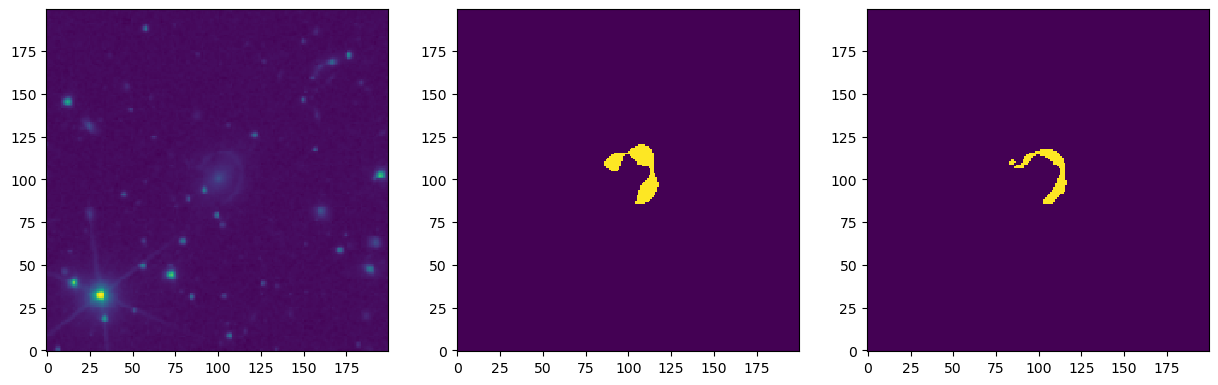

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.6723 :


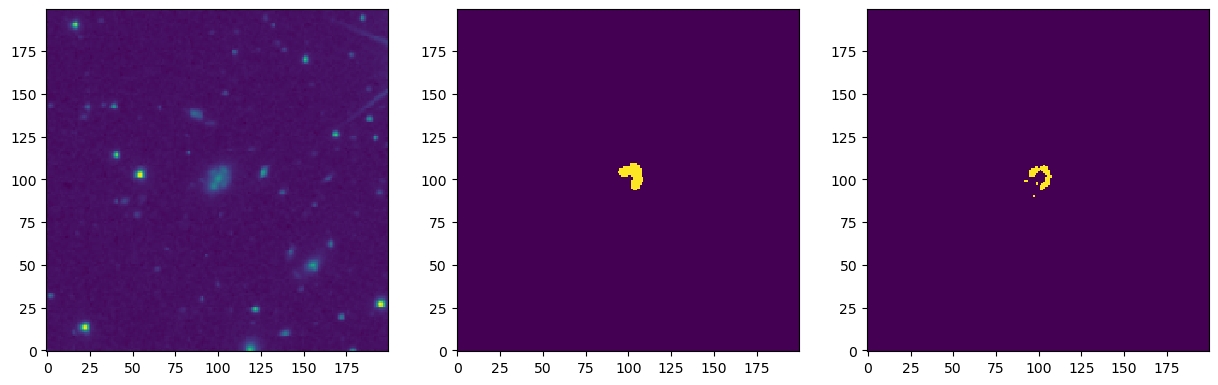

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.5948 :


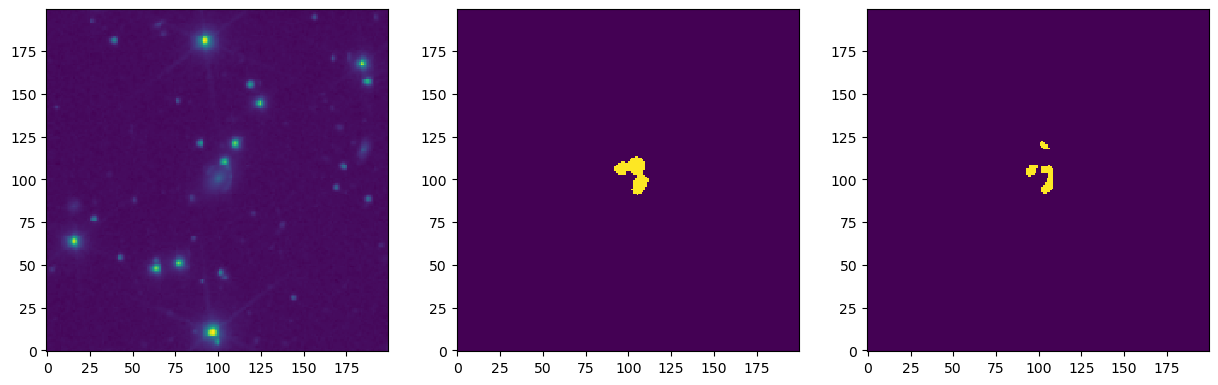

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.85 :


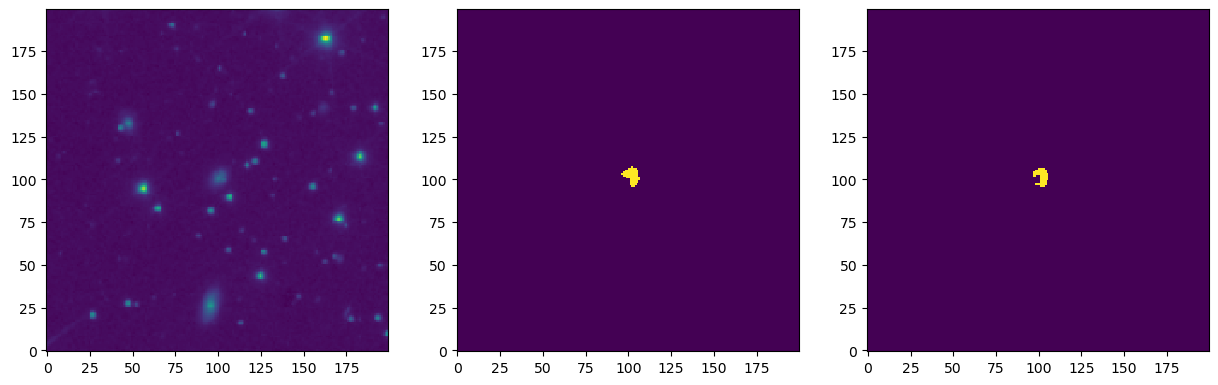

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.8061 :


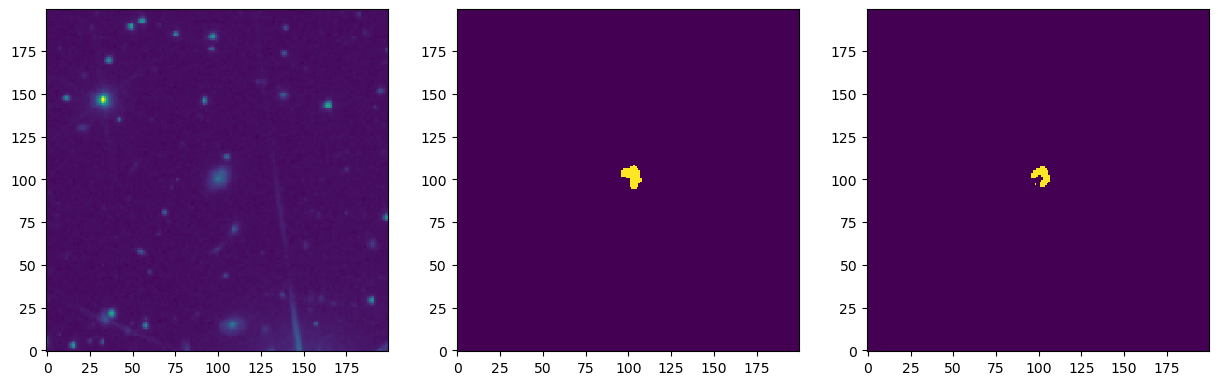

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.5455 :


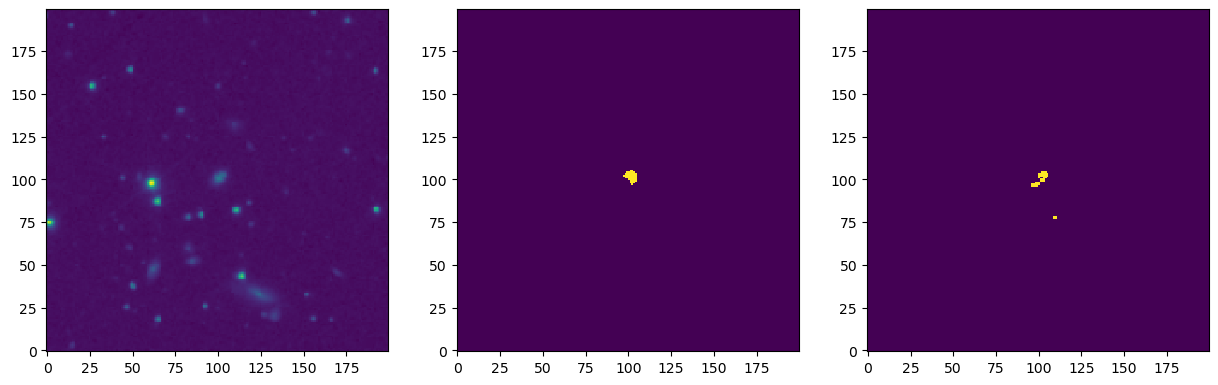

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.0 :


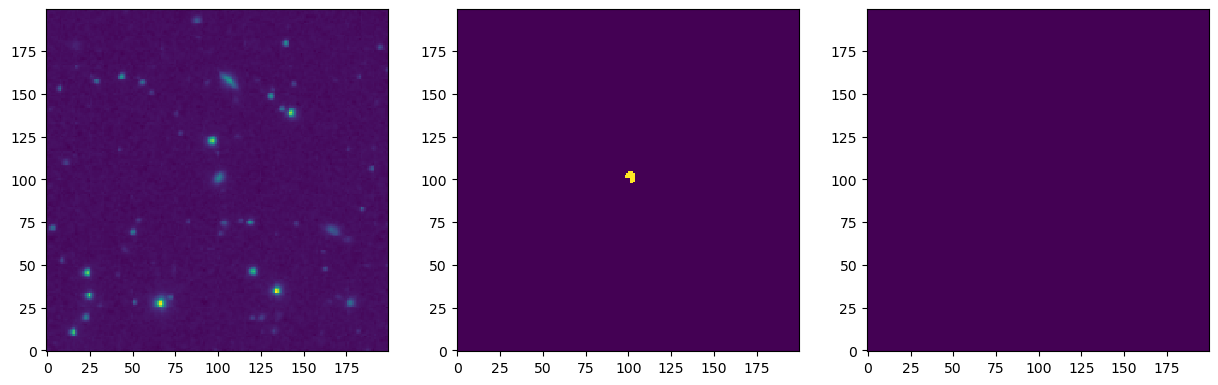

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.0 :


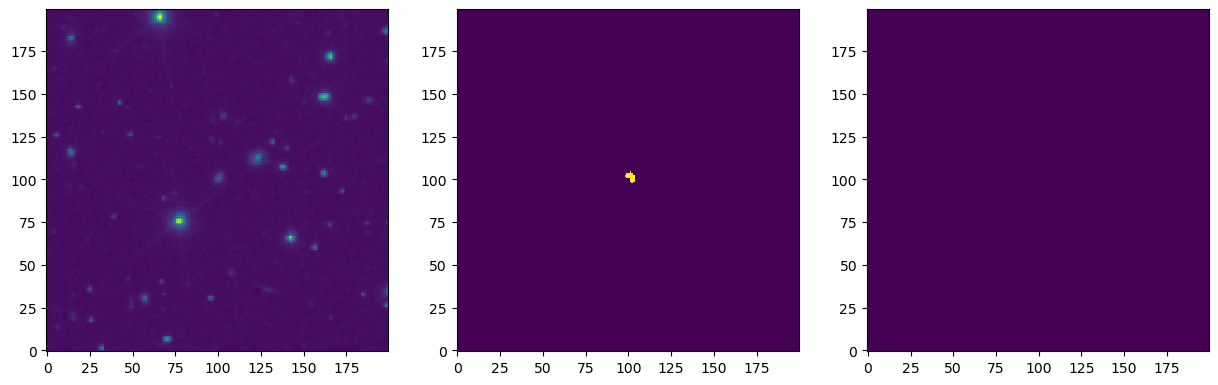

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_106_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.0 :


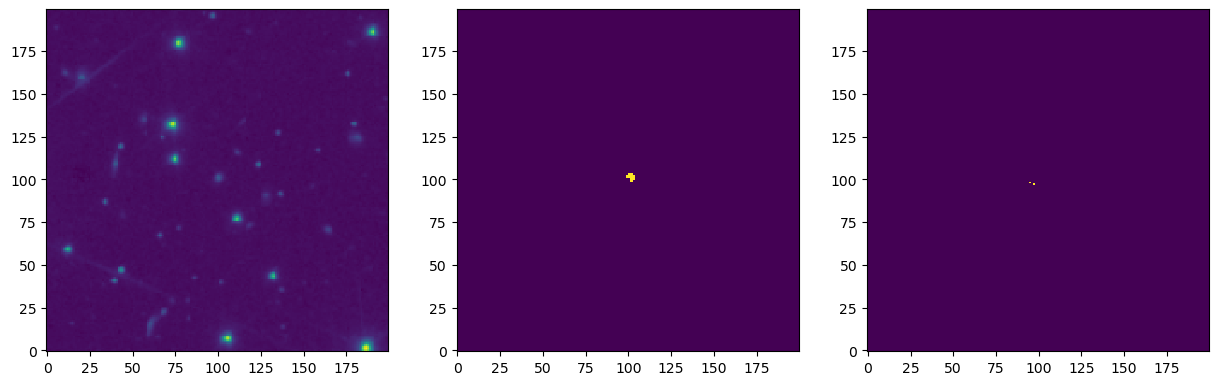

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.4336 :


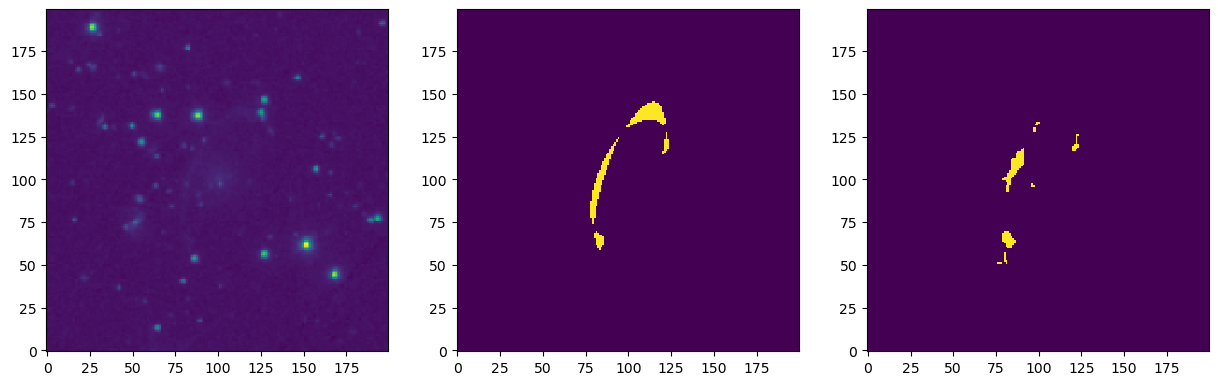

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.7802 :


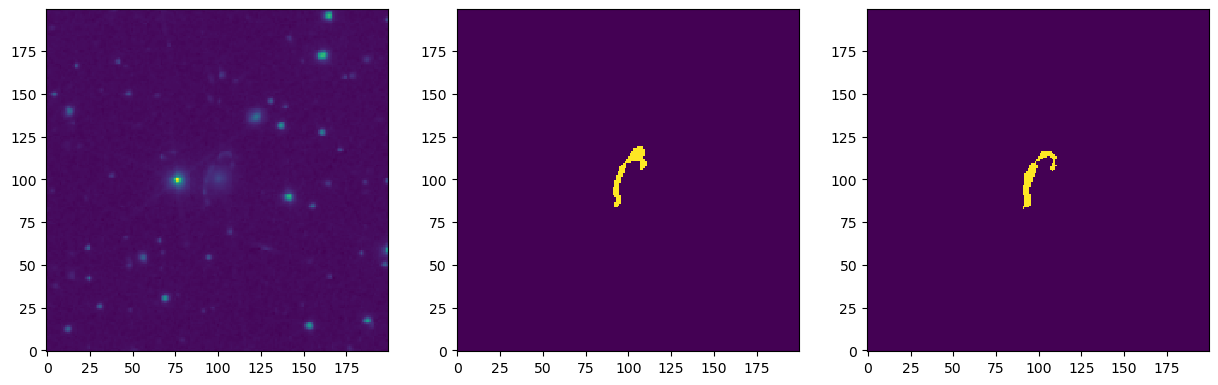

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.563 :


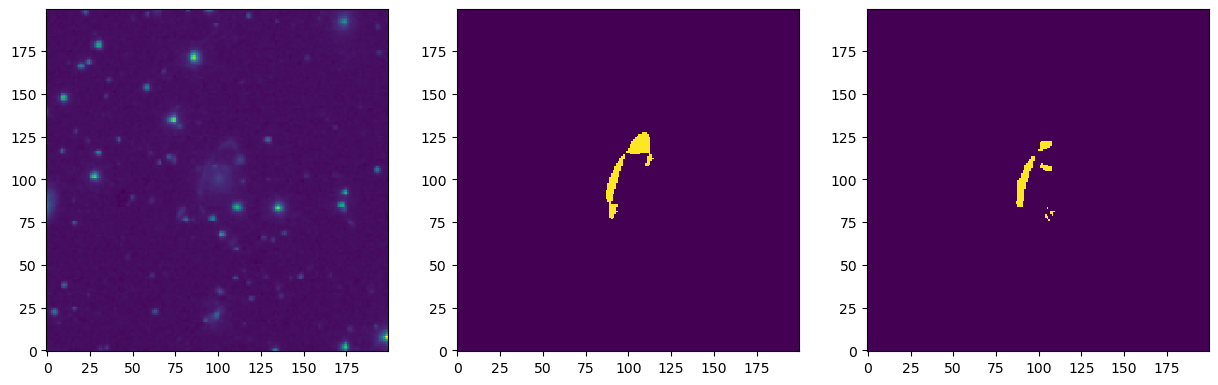

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.797 :


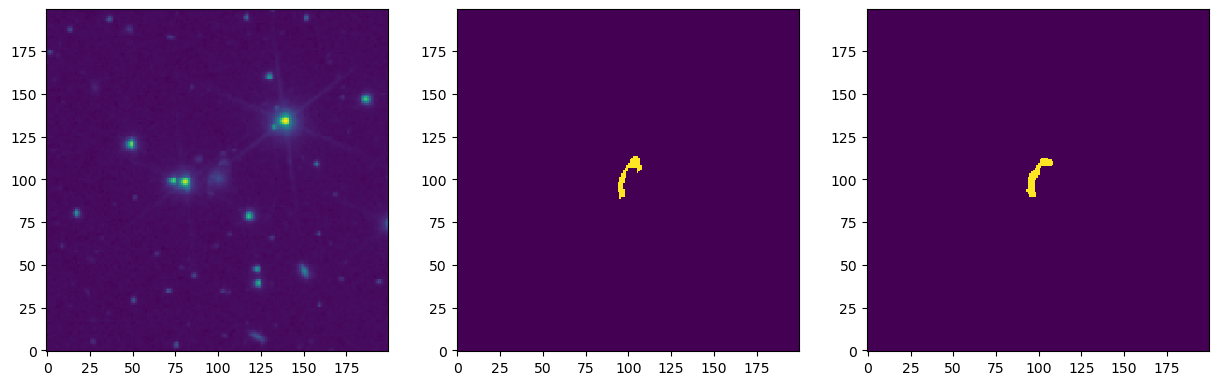

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.5241 :


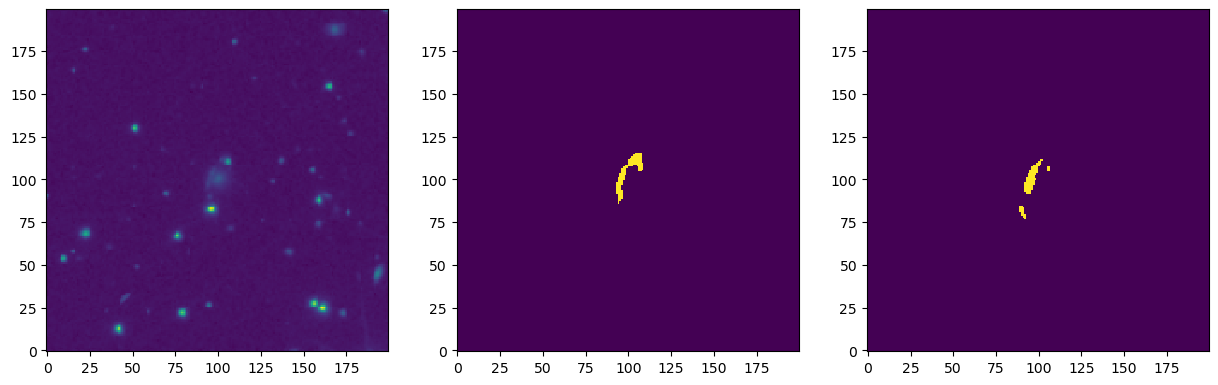

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.5 :


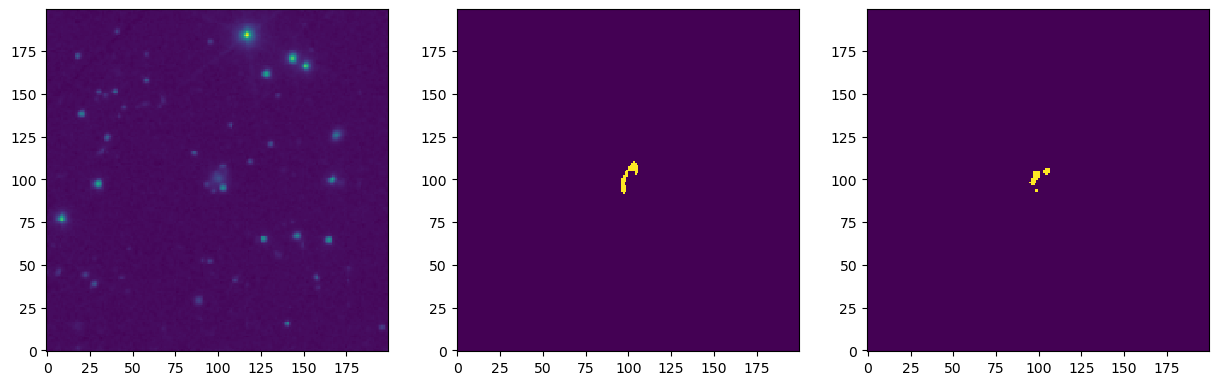

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.5789 :


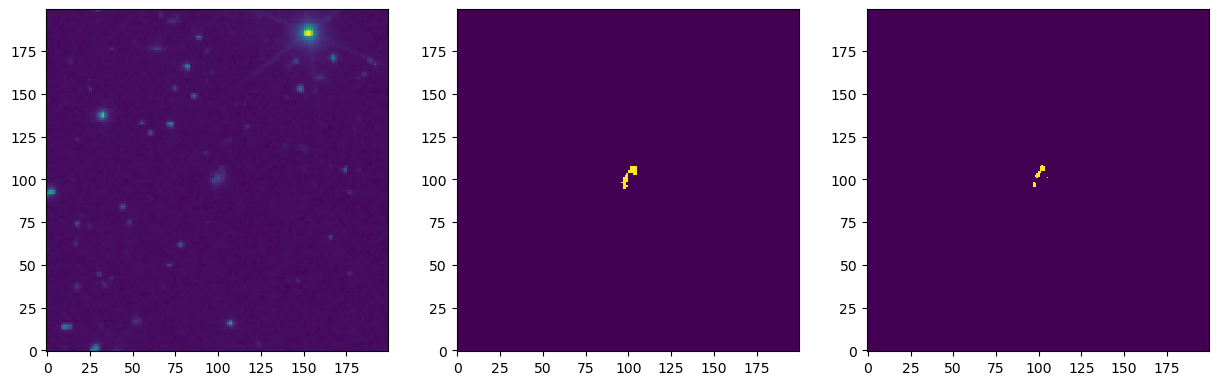

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.4118 :


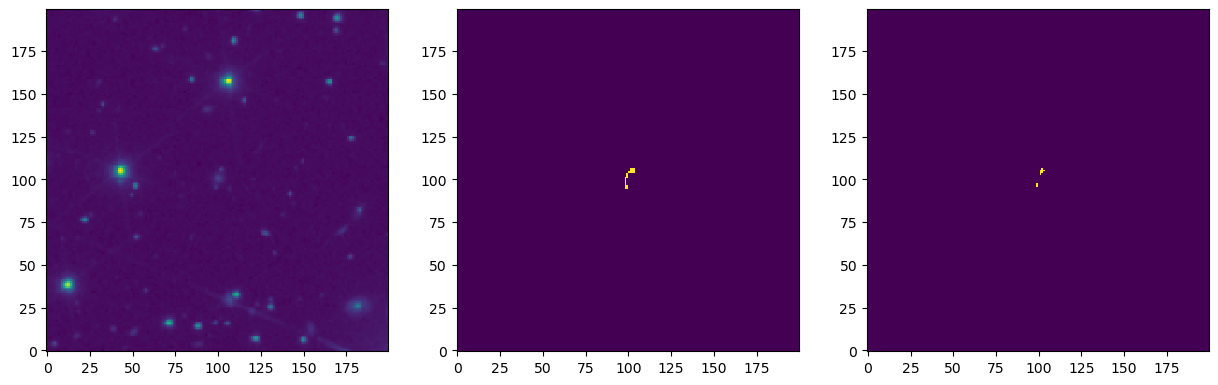

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_107_1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 1, Dice: 0.0367 :


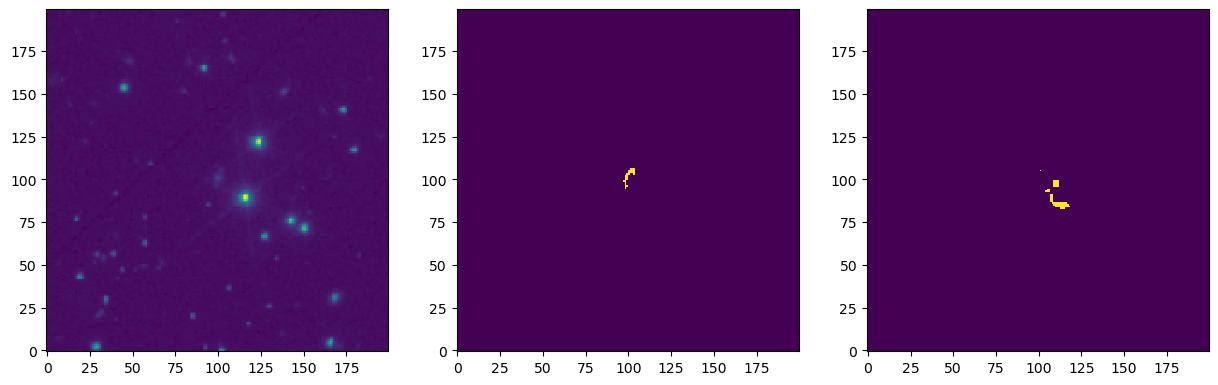

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.4222 :


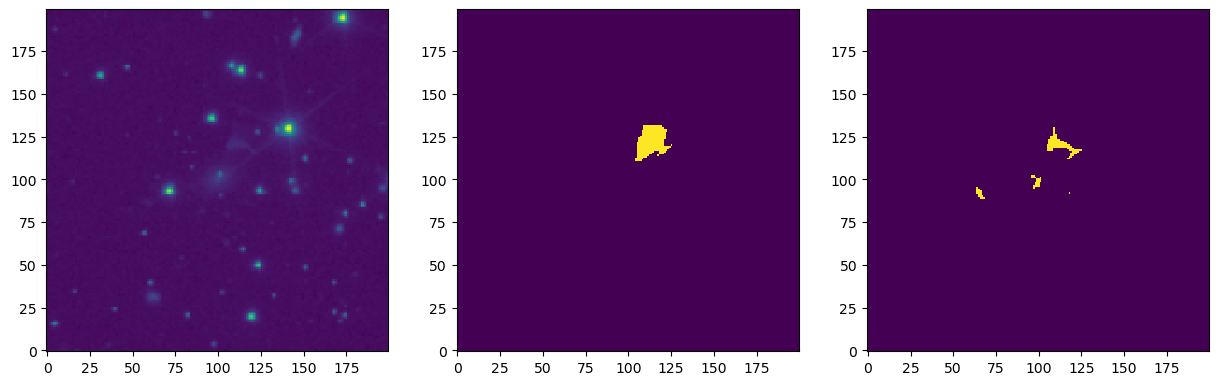

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.6026 :


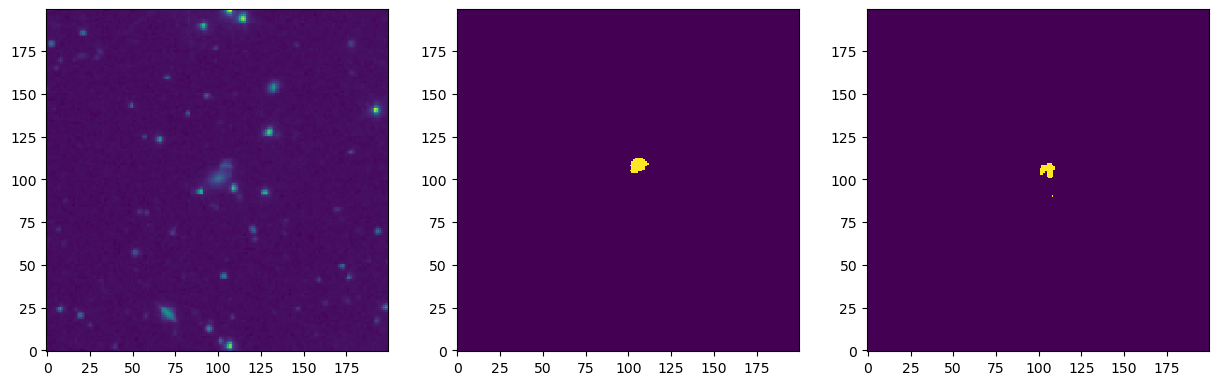

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.2905 :


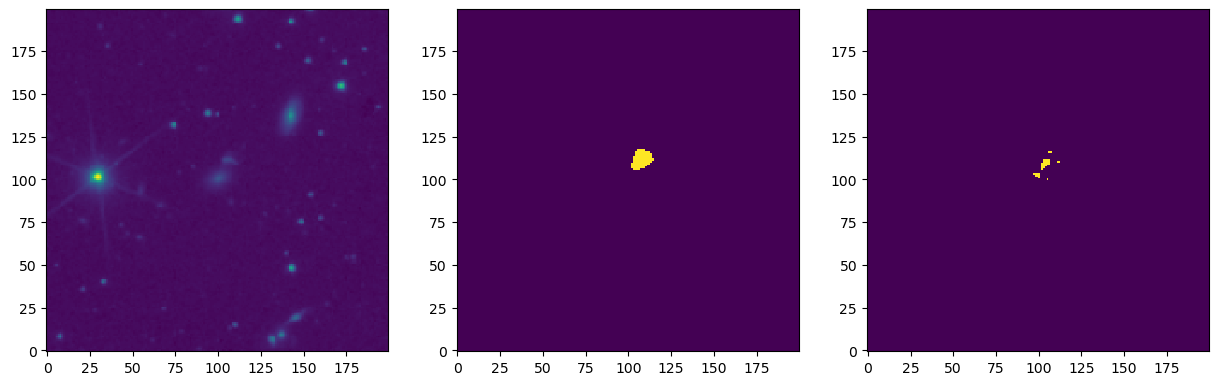

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.5846 :


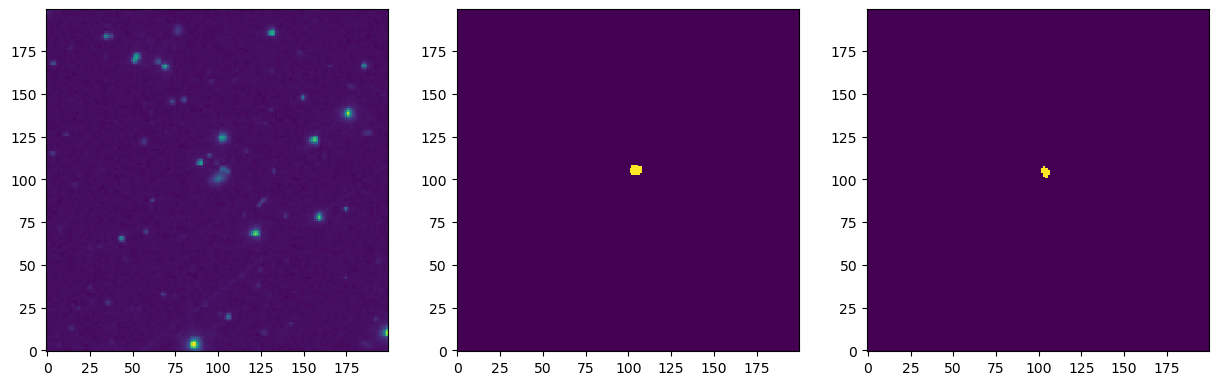

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.0952 :


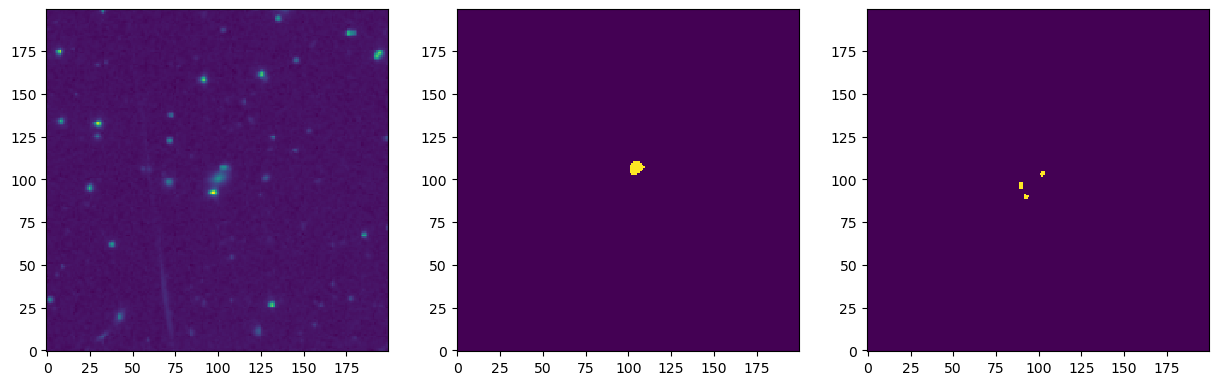

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.6341 :


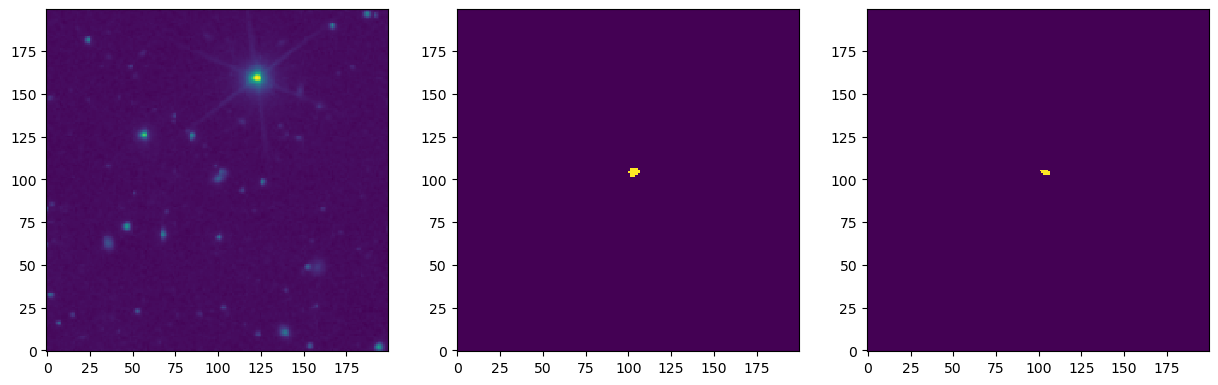

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.9091 :


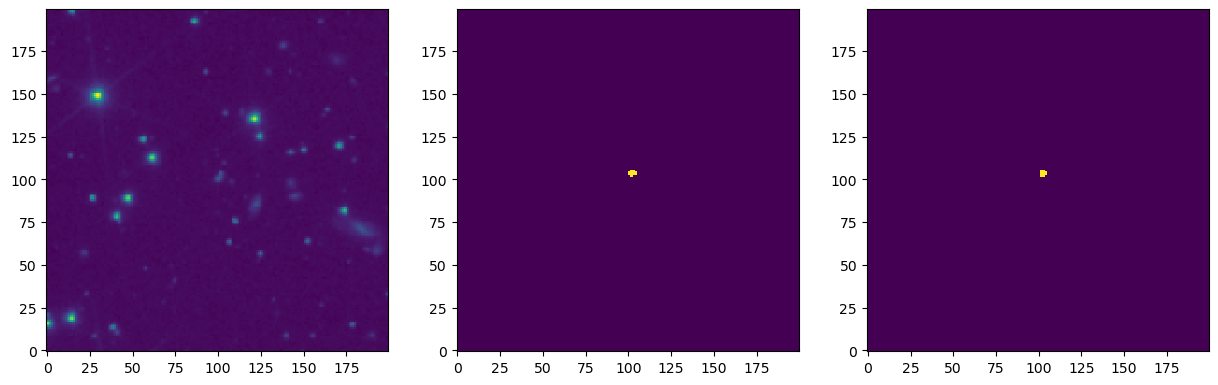

Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_108_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.0 :


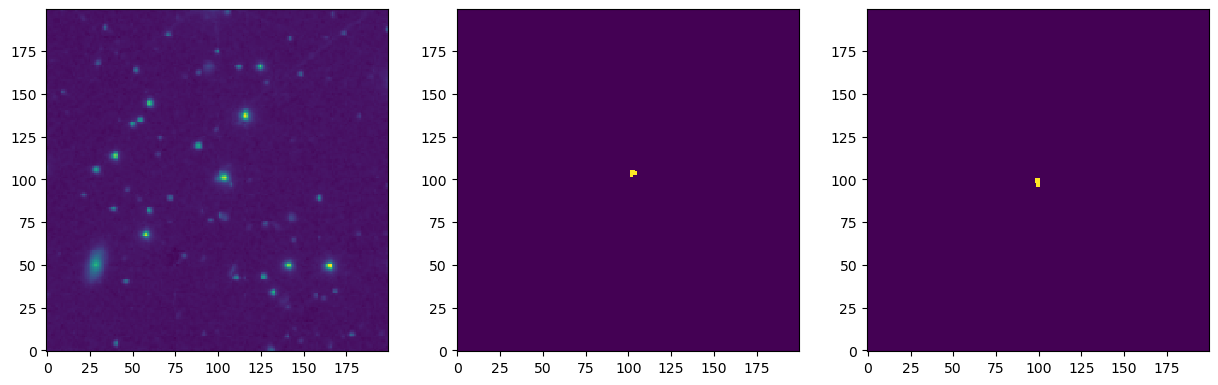

In [9]:
resultados = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
# With photos
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
mejor_modelo.eval()
pasos_test=0
dice_medio_test=0
zp = 30.137
pix_scale = 0.1
for i in range(int(len(test_dataset) * 0.05)):
    item_dataset = test_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Si la máscara es vacía no intentamos segmentarla, para que no cuente en el dice
    if(np.count_nonzero(item_label)!=0):
        #Obtenemos predicción de la red
        prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()   
        mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
        valor_dice = dice(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        magnitud = item_dataset[3]
        print("Ruta: "+item_dataset[2]+ "\nMagnitud: "+ magnitud + ", Dice: "+str(round(valor_dice.item(), 4))+" :")
        resultados[magnitud].append(valor_dice.item())
        dice_medio_test += valor_dice.item()
        pasos_test += 1
        #Mostramos imagen, mascara y mascara predicha
        item_x = cv2.resize(item_x.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        item_label = cv2.resize(item_label.astype(np.uint8), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)   
        mascara_predicha = cv2.resize(mascara_predicha.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))
        axs0.imshow(item_x, interpolation='none', origin="lower")
        axs1.imshow(item_label, interpolation='none', origin="lower")
        axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
        plt.show()
        #guardar_imagen_plt(item_x, "item_x", i)
        #guardar_imagen_plt(item_label, "item_label", i)
        #guardar_imagen_plt(mascara_predicha, "mascara_predicha", i)


In [10]:
resultados = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}
# Without photos
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
mejor_modelo.eval()
pasos_test=0
dice_medio_test=0
zp = 30.137
pix_scale = 0.1
for i in range(int(len(test_dataset))):
    item_dataset = test_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Si la máscara es vacía no intentamos segmentarla, para que no cuente en el dice
    if(np.count_nonzero(item_label)!=0):
        #Obtenemos predicción de la red
        prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()   
        mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
        valor_dice = dice(torch.from_numpy(item_label), torch.from_numpy(mascara_predicha))
        magnitud = item_dataset[3]
        print("Ruta: "+item_dataset[2]+ "\nMagnitud: "+ magnitud + ", Dice: "+str(round(valor_dice.item(), 4))+" :")
        resultados[magnitud].append(valor_dice.item())
        dice_medio_test += valor_dice.item()
        pasos_test += 1
        #Mostramos imagen, mascara y mascara predicha
        item_x = cv2.resize(item_x.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        item_label = cv2.resize(item_label.astype(np.uint8), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)   
        mascara_predicha = cv2.resize(mascara_predicha.astype(np.float32), (hiperparametros['ancho_imagen_original'], hiperparametros['alto_imagen_original']), interpolation = cv2.INTER_NEAREST)     
        #fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))
        #axs0.imshow(item_x, interpolation='none', origin="lower")
        #axs1.imshow(item_label, interpolation='none', origin="lower")
        #axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
        #plt.show()
        #guardar_imagen_plt(item_x, "item_x", i)
        #guardar_imagen_plt(item_label, "item_label", i)
        #guardar_imagen_plt(mascara_predicha, "mascara_predicha", i)


Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.05_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.05, Dice: 0.2527 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.15_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.15, Dice: 0.5487 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.1_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.1, Dice: 0.6717 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.25_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.25, Dice: 0.8426 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.2_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.2, Dice: 0.5 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.4_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.4, Dice: 0.5316 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.6_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.6, Dice: 0.8193 :
Ruta: galaxies_test_NISP_J/galaxy_and_stream_convolved_1000_0.8_NISP_J_in_IC342_NISP_J.fits
Magnitud: 0.8, Dice: 0.6977 :
Ruta: galaxies_test_N

In [11]:
dice_test_medio_total=dice_medio_test/pasos_test
print("Dice_medio_total="+str(dice_test_medio_total))

Dice_medio_total=0.447102329414071


/tmp/ipykernel_75409/3972039408.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(resultados.keys()), y=medias, palette='viridis')


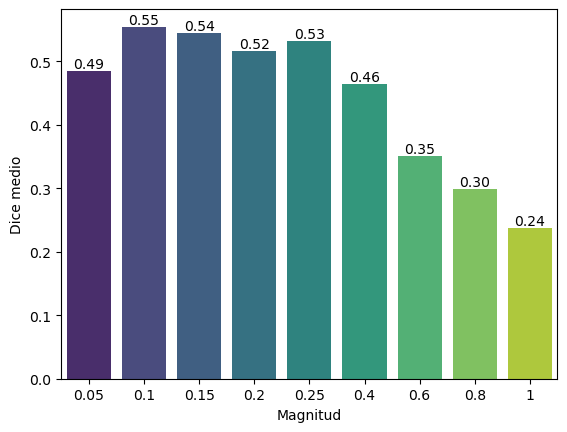

In [12]:
dices_medios_por_magnitud = medias = [np.mean(lista) for lista in resultados.values()]
ax = sns.barplot(x=list(resultados.keys()), y=medias, palette='viridis')
for i, valor in enumerate(medias):
    ax.text(i, valor, f'{valor:.2f}', ha='center', va='bottom')
plt.xlabel('Magnitud')
plt.ylabel('Dice medio')

# Mostrar el gráfico
plt.show()